# TESTING NOTEBOOK - SNOWSLIDE & RESOLUTION

Ce notebook a été créé pour résumer et interpréter l'effet de la résolution sur Snowslide. Les différentes figures et analyses présentes dans le rapport sont tirées de ce document en particulier. 
Les références au rapport sont des références au document situé au chemin suivant : "/NotebooksFinaux_rapport/Rapport_stage_Guillem_Carcanade_IGE2023.pdf"

In [17]:
import rasterio 
import numpy as np 
import matplotlib.pyplot as plt
from snowslide import *
from snowslide import functions

from rasterio.windows import Window
from rasterio.enums import Resampling

from tqdm import tqdm
from snowslide.snowslide_main import snowslide_base
import os

## 0) Création de DEM synthétiques 

On va chercher à travailler avec 1 ou 2 DEM synthétiques classiquement utilisés pendant le stage. En particulier il est intéressant de regarder les résultats sur un DEM qui simule une topographie avec des couloirs (figure 11.a du rapport) et un DEM qui simule une topographie linéaire avec rupture de pente (figure 7.b du rapport). On produit alors différentes versions de ces DEM identiques mais de résolutions différentes. L'objectif est de faire tourner Snowslide sur ces différentes résolutions et d'analyser les résultats et leurs différences. 

La fonction "resampling_dem" dans le module functions de Snowslide permet de modifier la résolution d'un DEM d'un facteur choisi. Le code suivant est celui qui a été utilisé pour générer des DEM de résolutions différentes et stockés dans le dossier Data. 

In [2]:
# factor = 1/4
# src_path = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_10m.tif"
# dst_path = f"/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_{10/factor}m.tif"
# functions.resampling_dem(src_path,dst_path,factor)

# res = rasterio.open(dst_path).res
# print(res)
# plt.imshow(rasterio.open(dst_path).read(1))
# plt.colorbar()

Initialement, le travail a été proposé pour 6 DEMs différents. Puis les besoins d'analyse ont montré l'intérêt de générer un grand nombre de DEM différents. C'est pourquoi nous les générons déjà dès le début. 

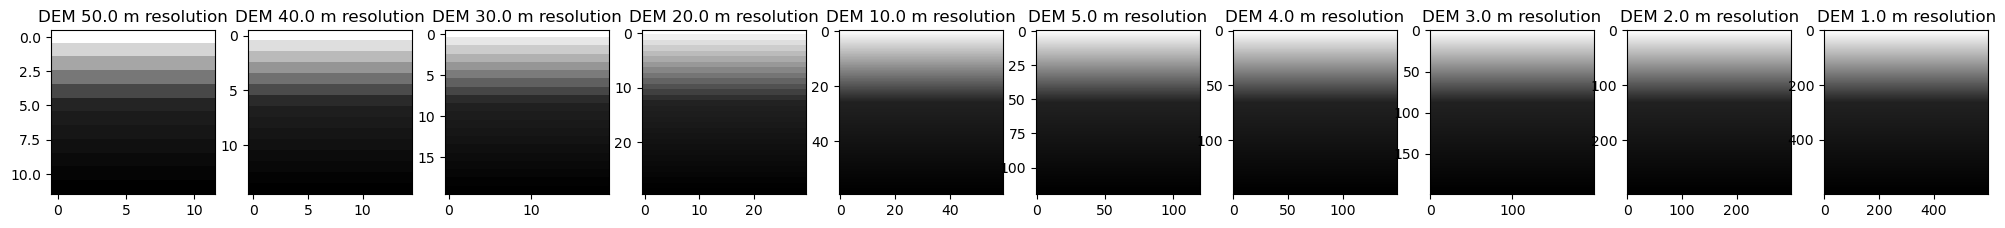

In [5]:
# Import et affichage de différents DEMs
dem_path1 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_50.0m.tif"
dem_path2 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_40.0m.tif"
dem_path3 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_30.0m.tif"
dem_path4 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_20.0m.tif"
dem_path5 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_10m.tif"
dem_path6 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_5.0m.tif"
dem_path7 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_4.0m.tif"
dem_path8 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_3.0m.tif"
dem_path9 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_2.0m.tif"
dem_path10 = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_1.0m.tif"
dem_paths = [dem_path1,dem_path2,dem_path3,dem_path4,dem_path5,dem_path6,dem_path7,dem_path8,dem_path9,dem_path10]

# srcs contient les informations rasterio de tous les dem sous forme de liste
srcs = []
for elt in dem_paths:
    srcs.append(rasterio.open(elt))

# Plotting
fig,ax = plt.subplots(1,len(dem_paths),figsize=(25,3))
for i in range(len(srcs)) :
    plot = ax[i].imshow(srcs[i].read(1),cmap='gray')
    ax[i].set_title(f"DEM {srcs[i].res[0]} m resolution")

## 1) Lancement des simulations Snowslide

A partir de la liste srcs on lance alors les simulations snowslide. On choisit également de stocker des statistiques sur les résultats afin d'en faciliter l'analyse : 
Comme décrit dans le rapport on considère comme un dépôt tout pixel dont la hauteur après convergence est supérieure strictement à la hauteur initiale de neige qui lui est associée. 
- deposit_area : Nombre de pixels associés à un dépôt x resolution 
- deposit_volume : Somme des pixels associés à un dépôt x résolution 
- max_height : Pixel d'un dépôt associé à la hauteur maximale
- deposit_max_distance : Longuer maximale du dépôt dans le sens des colonnes (nb de pixels x résolution)

In [10]:
from snowslide.snowslide_main import snowslide_base

# On lance snowslide sur ces DEMs
SNDs = []
SND_stats = []
statistics = []
for dem_path in tqdm(dem_paths, desc="Avancée du calcul ", unit="dems"): # Un simple moyen d'afficher une progress_bar
    # Inputs
    init = 1.0
    dem = rasterio.open(dem_path).read(1)
    #SND0 = np.full(np.shape(dem),1.0)
    snd0 = np.zeros(np.shape(dem))
    snd0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True,"compute_edges":True}
    
    # Simulation
    snd = snowslide_base(dem_path,snd0,param_routing=param_routing)
    SNDs.append(snd)

    # Statistiques
    dic = {}
    SND_test = np.copy(snd)
    SND_test[np.where(snd <= snd0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    SND_stats.append(SND_test)
    statistics.append(dic)

Avancée du calcul :   0%|          | 0/10 [00:00<?, ?dems/s]/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
Avancée du calcul :  20%|██        | 2/10 [00:00<00:00, 15.23dems/s]/Users/llemcf/mambaforge/envs/oggm_e

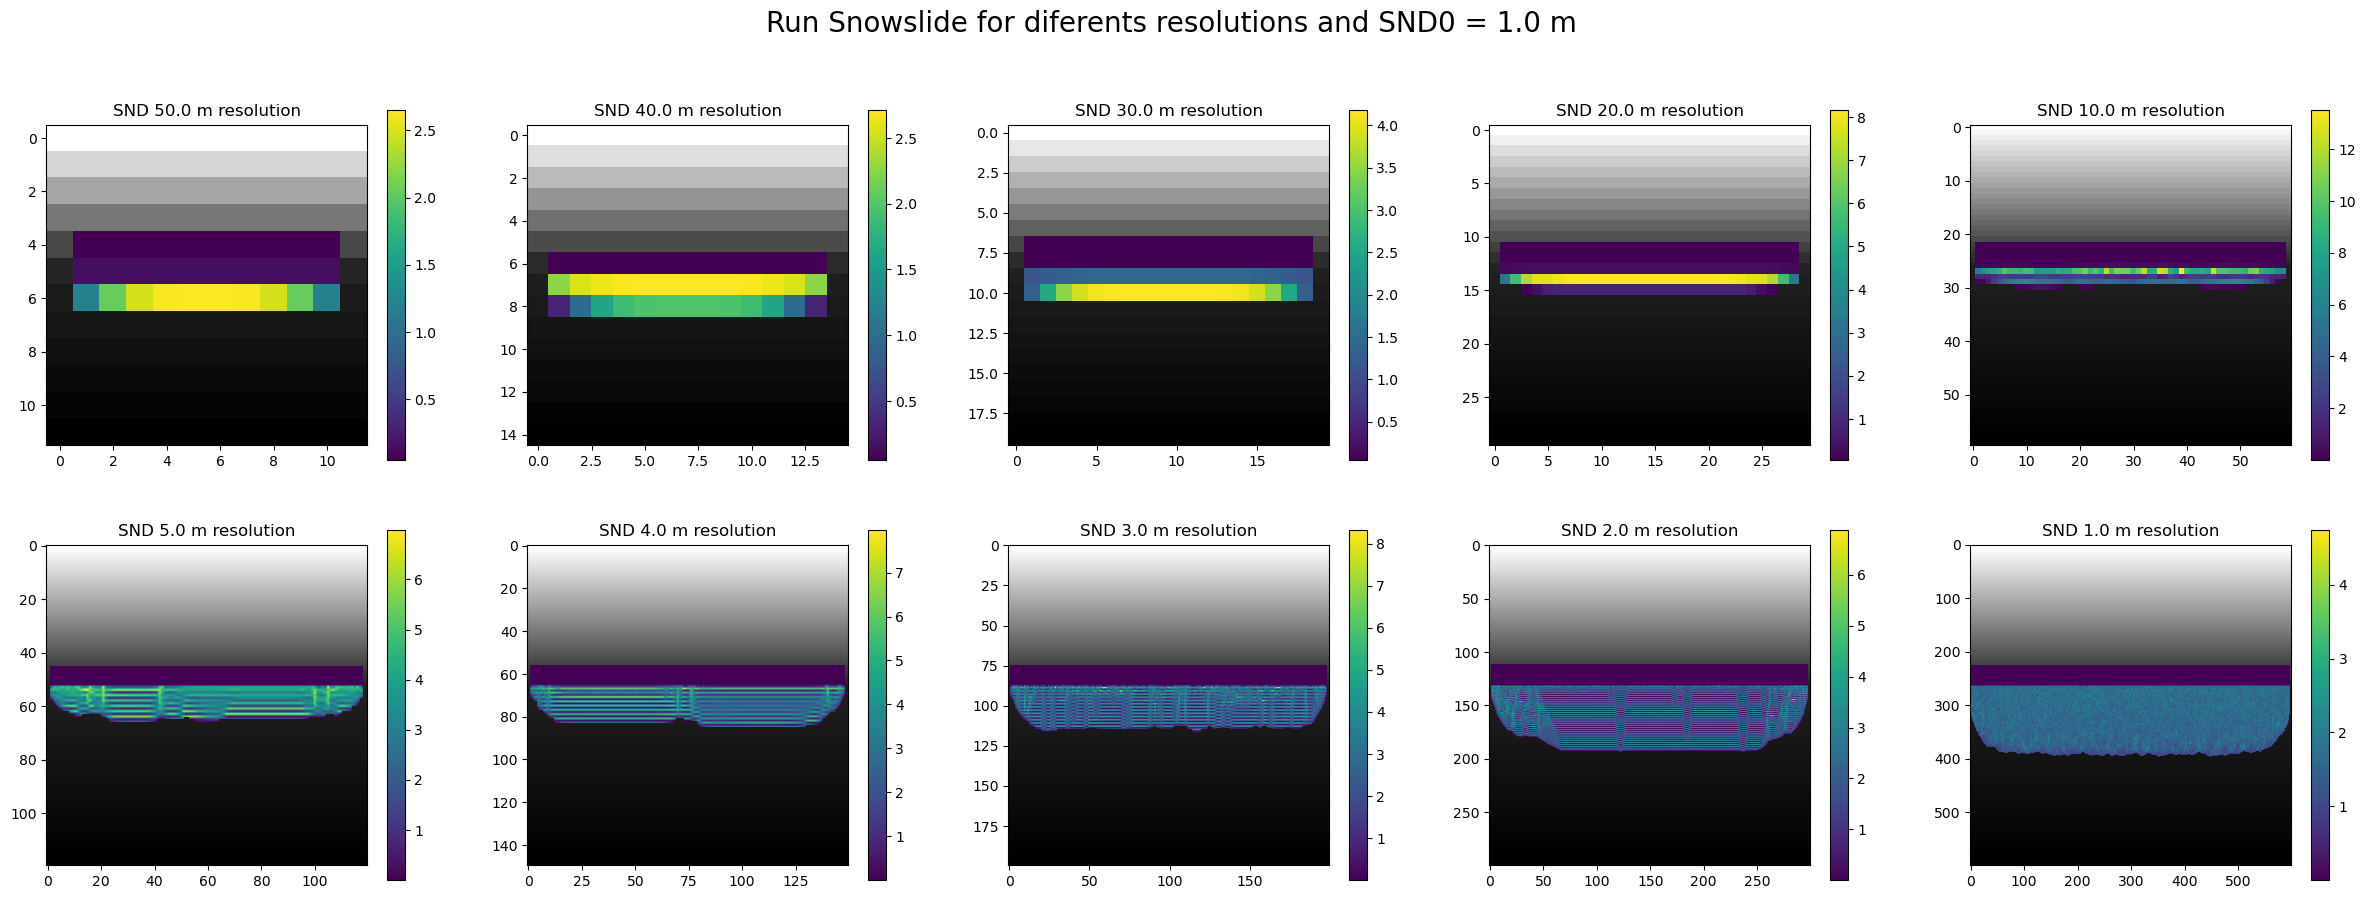

In [11]:
# Affichage des résultats de sortie Snowslide (zones de dépôts uniquement)
fig,ax = plt.subplots(2,5,figsize=(30,10))
for i in range(5) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)

    ax[0,i].imshow(srcs[i].read(1),cmap='gray')
    plot = ax[0,i].imshow(SND_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    
    ax[1,i].imshow(srcs[i+5].read(1),cmap='gray')
    plot = ax[1,i].imshow(SND_stats[i+5])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+5].res[0]} m resolution")

Comme observé à plusieurs reprises durant le stage, on constate que la résolution semble avoir un effet significatif sur les sorties proposées par Snowslide. Notamment à partir d'une certaine résolution, les résultats semblent très bruités, perdre de la symétrie et être plus long dans le sens de la pente. Vérifions ces constatations visuelles en regardant les résultats issus des calculs statistiques. 

Text(0.5, 1.0, 'Max heights on the dems')

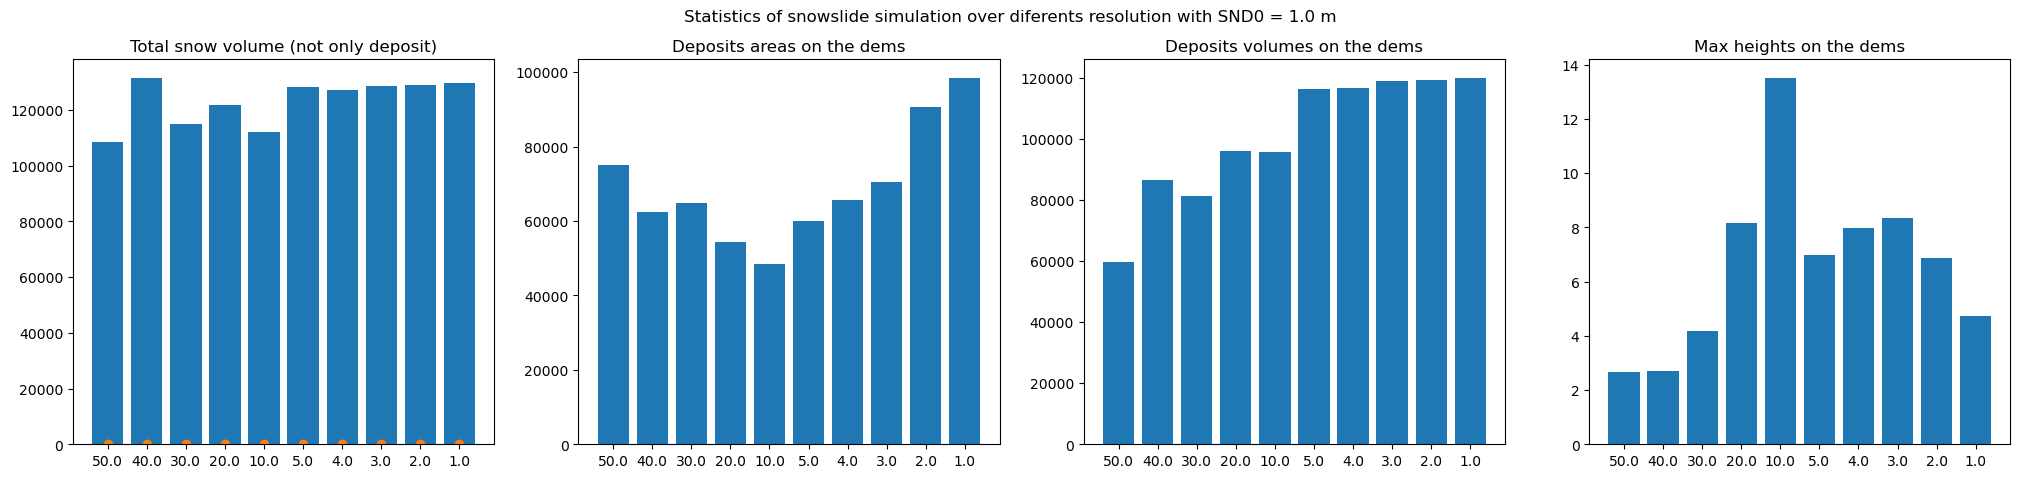

In [13]:
areas = []
volumes = []
heights = []
total_volume = []
init_volume = []
resol_dems = []
for i in range(len(dem_paths)):
    SND0 = np.zeros(np.shape(srcs[i].read(1)))
    SND0[np.where(srcs[i].read(1) > 800)] = init
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    total_volume.append(np.sum(SNDs[i])*(srcs[i].res[0])**2)
    init_volume.append(np.sum(SND0)*(srcs[i].res[0])**2)
    
    resol_dems.append(str(srcs[i].res[0]))

fig,ax = plt.subplots(1,4,figsize=(25,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,total_volume)
ax[0].scatter(resol_dems,init_volume)
ax[0].set_title('Total snow volume (not only deposit)')
ax[1].bar(resol_dems,areas)
ax[1].set_title('Deposits areas on the dems')
ax[2].bar(resol_dems,volumes)
ax[2].set_title('Deposits volumes on the dems')
ax[3].bar(resol_dems,heights)
ax[3].set_title('Max heights on the dems')

Text(0, 0.5, 'Longueur de dépôt (m)')

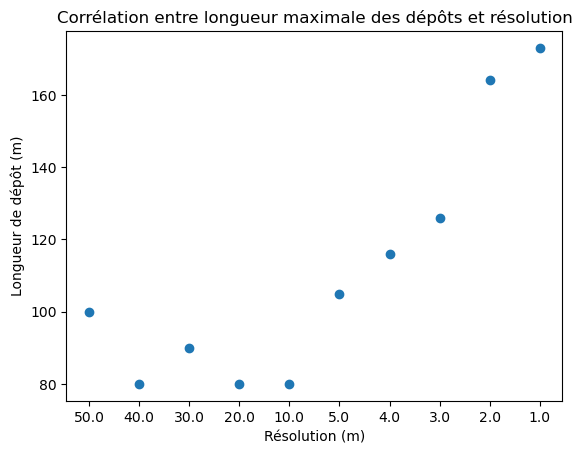

In [16]:
# Calcul de la longueur max des dépôts en fonction de la résolution 
deposit_length = []
for i in range(len(SND_stats)) :
    resolution = srcs[i].res[0]
    SND_test = SND_stats[i]
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    length = (max_index - min_index)*resolution
    deposit_length.append(length)

# Plotting 
plt.scatter(resol_dems,deposit_length)
plt.title("Corrélation entre longueur maximale des dépôts et résolution")
plt.xlabel("Résolution (m)")
plt.ylabel("Longueur de dépôt (m)")

Il semblerait qu'on identifie très franchement un lien entre distance moyene du dépôt et résolution. En particulier, il semblerait que à des résolutions inférieures à 10m cela ne soit pas significatif mais que cela le devienne pour des résolutions supérieures à 10m. Cela pourrait valoir le coup d'approfondir ce lien en traçant ce même plot à partir de plus de données statistiques afin de vérifier l'existence de ces deux dynamiques différentes. 

In [18]:
# On créé un dossier avec plein de DEMs de résolution différente
resolutions = np.arange(1,60.5,0.5)
for res in resolutions :
    factor = 10/res
    src_path = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_10m.tif"
    dst_path = f"/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_{res}m.tif"
    if not os.path.exists(dst_path): 
        functions.resampling_dem(src_path,dst_path,factor)

In [30]:
# On liste les éléments du dossier 
import os
dossier = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM" # A remplacer par le chemin vers votre dossier équivalent
if os.path.exists(dossier) and os.path.isdir(dossier):
    dem_paths = [os.path.join(dossier, element) for element in os.listdir(dossier)]

# On lance snowslide sur ces DEMs
statistics = []
SND_tot = []
i = 0
for dem_path in dem_paths :
    # Inputs
    init = 1
    dem = rasterio.open(dem_path).read(1)

    snd0 = np.zeros(np.shape(dem))
    snd0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True,"compute_edges":True}
    
    # Simulation
    snd = snowslide_base(dem_path,snd0=snd0,param_routing=param_routing)
    SND_tot.append(snd)

    # Statistiques
    dic = {}
    SND_test = np.copy(snd)
    SND_test[np.where(snd <= snd0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    statistics.append(dic)
    i = i+1
    print(f"##### Complété : {(i/120)*100}%")


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 0.8333333333333334%
##### Complété : 1.6666666666666667%
##### Complété : 2.5%
##### Complété : 3.3333333333333335%
##### Complété : 4.166666666666666%
##### Complété : 5.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 5.833333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 6.666666666666667%
##### Complété : 7.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 8.333333333333332%
##### Complété : 9.166666666666666%
##### Complété : 10.0%
##### Complété : 10.833333333333334%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 11.666666666666666%
##### Complété : 12.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 13.333333333333334%
##### Complété : 14.166666666666666%
##### Complété : 15.0%
##### Complété : 15.833333333333332%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 16.666666666666664%
##### Complété : 17.5%
##### Complété : 18.333333333333332%
##### Complété : 19.166666666666668%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 20.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 20.833333333333336%
##### Complété : 21.666666666666668%
##### Complété : 22.5%
##### Complété : 23.333333333333332%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 24.166666666666668%
##### Complété : 25.0%
##### Complété : 25.833333333333336%
##### Complété : 26.666666666666668%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 27.500000000000004%
##### Complété : 28.333333333333332%
##### Complété : 29.166666666666668%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 30.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 30.833333333333336%
##### Complété : 31.666666666666664%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 32.5%
##### Complété : 33.33333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 34.166666666666664%
##### Complété : 35.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 35.833333333333336%
##### Complété : 36.666666666666664%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 37.5%
##### Complété : 38.333333333333336%
##### Complété : 39.166666666666664%
##### Complété : 40.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 40.833333333333336%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 41.66666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 42.5%
##### Complété : 43.333333333333336%
##### Complété : 44.166666666666664%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 45.0%
##### Complété : 45.83333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 46.666666666666664%
##### Complété : 47.5%
##### Complété : 48.333333333333336%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 49.166666666666664%
##### Complété : 50.0%
##### Complété : 50.83333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 51.66666666666667%
##### Complété : 52.5%
##### Complété : 53.333333333333336%
##### Complété : 54.166666666666664%
##### Complété : 55.00000000000001%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 55.833333333333336%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 56.666666666666664%
##### Complété : 57.49999999999999%
##### Complété : 58.333333333333336%
##### Complété : 59.166666666666664%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 60.0%
##### Complété : 60.83333333333333%
##### Complété : 61.66666666666667%
##### Complété : 62.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 63.33333333333333%
##### Complété : 64.16666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 65.0%
##### Complété : 65.83333333333333%
##### Complété : 66.66666666666666%
##### Complété : 67.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 68.33333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 69.16666666666667%
##### Complété : 70.0%
##### Complété : 70.83333333333334%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 71.66666666666667%
##### Complété : 72.5%
##### Complété : 73.33333333333333%
##### Complété : 74.16666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 75.0%
##### Complété : 75.83333333333333%
##### Complété : 76.66666666666667%
##### Complété : 77.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 78.33333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 79.16666666666666%
##### Complété : 80.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 80.83333333333333%
##### Complété : 81.66666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 82.5%
##### Complété : 83.33333333333334%
##### Complété : 84.16666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 85.0%
##### Complété : 85.83333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 86.66666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 87.5%
##### Complété : 88.33333333333333%
##### Complété : 89.16666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 90.0%
##### Complété : 90.83333333333333%
##### Complété : 91.66666666666666%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 92.5%
##### Complété : 93.33333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 94.16666666666667%
##### Complété : 95.0%
##### Complété : 95.83333333333334%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

##### Complété : 96.66666666666667%
##### Complété : 97.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 98.33333333333333%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 99.16666666666667%
##### Complété : 100.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


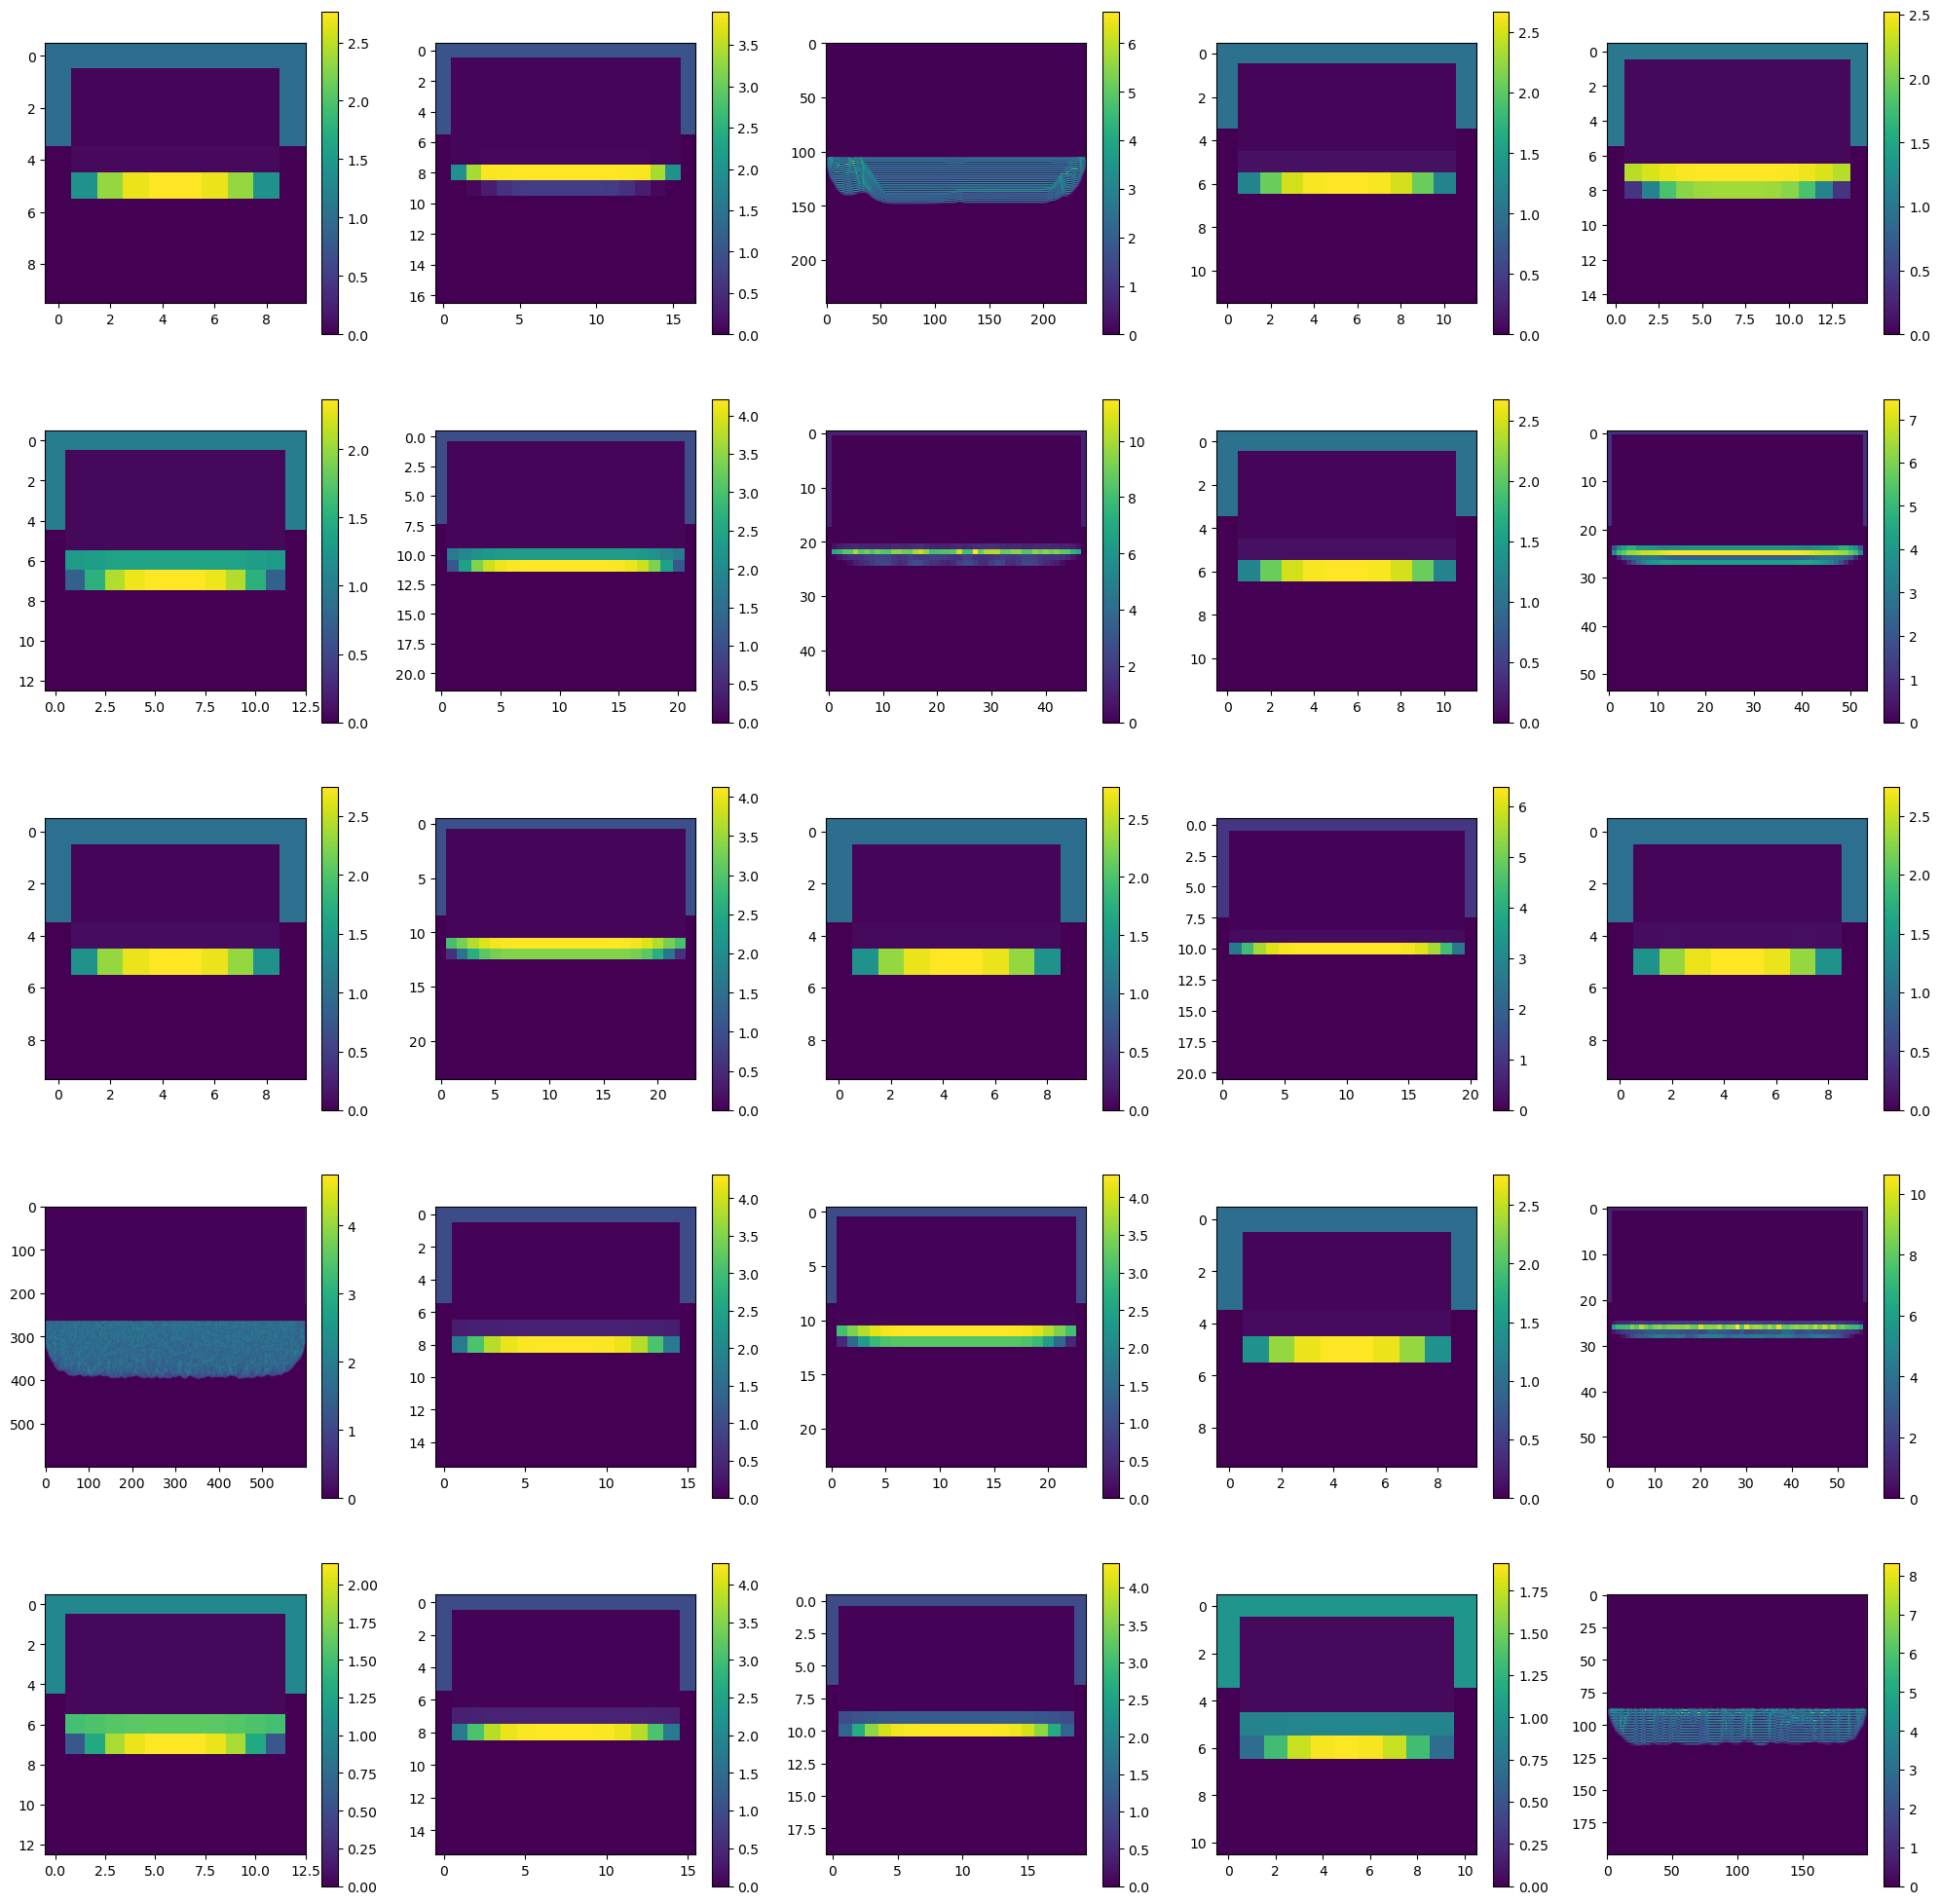

In [31]:
# Visualisation des 25 premiers résultats (s'assurer que ça a marché)
fig,ax = plt.subplots(5,5,figsize=(25,25))
iter = 0
for i in range(5) :
    for j in range(5) :
        plot = ax[i,j].imshow(SND_tot[iter])
        plt.colorbar(plot,ax=ax[i,j])
        iter = iter + 1

Text(0.5, 1.0, 'Evolution de la longueur des dépôts selon la résolution')

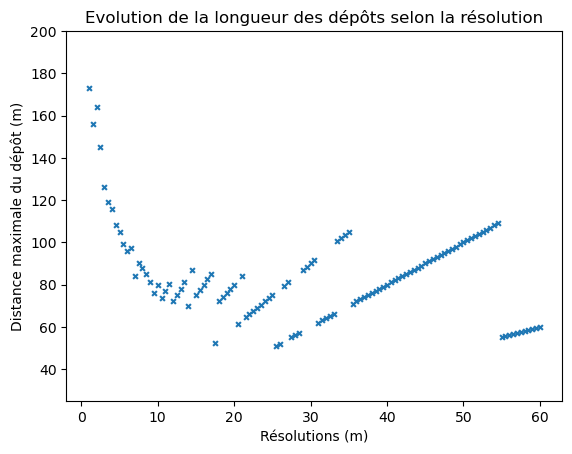

In [40]:
x = []
y = []
for i in range(len(dem_paths)) :
    x.append(rasterio.open(dem_paths[i]).res[0])
    y.append(statistics[i]["deposit_max_distance"])
plt.scatter(x,y,marker="x",s=12)
plt.xlabel('Résolutions (m)')
plt.ylim(25,200) # Il y a une valeur aberrante à 4000
plt.ylabel('Distance maximale du dépôt (m)')
plt.title('Evolution de la longueur des dépôts selon la résolution')

Voir l'analyse développée dans le rapport.

On choisit de pousser l'analyse et de recommencer l'expérience pour différentes hauteurs initiales. En effet les analyses ont montré que ce qui semblait importer était le ratio hauteur initiale sur resolution. (snd0/resolution). On charge alors les résultats dans des tableaux numpy comme réalisé à partir du code suivant. Les statistiques de longueurs de dépôts sont ensuite analysées à partir de l'affichage des figures comme suit.  

In [193]:
# array = np.array([x,y])
# np.save("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.2.npy",array)

#### Affichage de tous les graphes ensembles

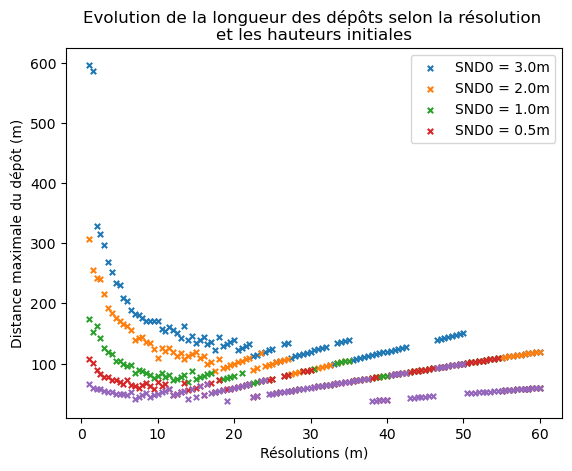

In [53]:
# Les chemins d'accès sont à adapter aux path spécifiques de l'utilisateur
y0 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.2.npy") 
y1 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.5.npy") 
y2 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND01.npy") 
y3 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND2.0.npy")
y4 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND3.0.npy")
plt.scatter(y4[0],y4[1],marker="x",s=15)
plt.scatter(y3[0],y3[1],marker="x",s=15)
plt.scatter(y2[0],y2[1],marker="x",s=15)
plt.scatter(y1[0],y1[1],marker="x",s=15)
plt.scatter(y0[0],y0[1],marker="x",s=15)
plt.xlabel('Résolutions (m)')
plt.ylabel('Distance maximale du dépôt (m)')
plt.title('Evolution de la longueur des dépôts selon la résolution \net les hauteurs initiales',fontsize=12)
plt.legend(['SND0 = 3.0m','SND0 = 2.0m','SND0 = 1.0m','SND0 = 0.5m'])
#plt.xlim(0.5,40)

In [42]:
# définition d'une fonction de régression linéaire
def reg_lin(x,y,label={'x':'x','y':'y','label':'data','title':'Régression linéaire sur les données'}) :
    # importations
    import matplotlib.pyplot as plt
    import numpy as np

    # Effectuer la régression linéaire
    coefficients = np.polyfit(x, y, 1)
    p = np.poly1d(coefficients)

    # Créer un vecteur de valeurs prédites
    x_pred = np.linspace(min(x), max(x), 100)
    y_pred = p(x_pred)

    # Tracer les points et la régression linéaire
    plt.scatter(x, y, label=label['label'])
    plt.plot(x_pred, y_pred, color='red', label=f'Régression linéaire : {coefficients[0]:.2f}x + {coefficients[1]:.2f}')

    # Ajouter des étiquettes et la légende
    plt.xlabel(label['x'])
    plt.ylabel(label['y'])
    plt.title(label['title'])
    plt.legend()

    # Afficher le graphique
    plt.show()

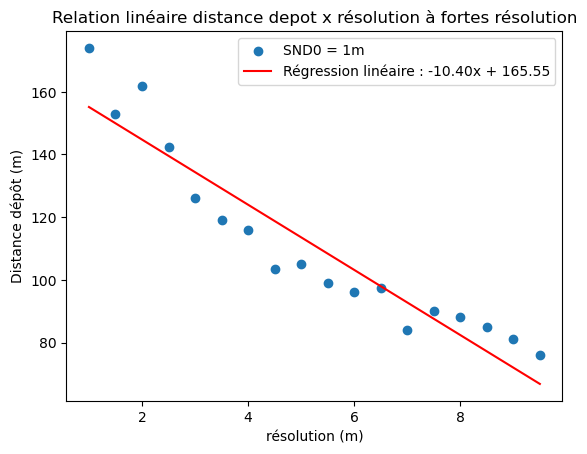

In [45]:
# Régression affine sur les points de résol - de 10m pour SND0 = 1m
points = y2[1][np.where(y2[0]<10)]
abs = y2[0][np.where(y2[0]<10)]
reg_lin(abs,points,label={'x':'résolution (m)','y':'Distance dépôt (m)','label':'SND0 = 1m','title':'Relation linéaire distance depot x résolution à fortes résolution'})

Il semblerait qu'on identifie systématiquement la même tendance. Celle-ci est décrite avec plus de précision dans le rapport. Mais on observe aux fortes résolutions une "explosion" exponentielle des distances de dépôt. Aux faibles résolutions en revanche les résultats sont moins significatifs et on peut postuler un faible impact de la résolution sur les simulations (elle restent confinées dans un intervalle d'incertitude...). Il est donc intéressant d'identifier pour une hauteur initiale de neige donnée, une résolution à partir de laquelle Snowslide ne peux plus fonctionner sans "sortir" de cet intervalle. 

De manière visuelle, on constate que les valeurs de distances "n'explosent" pas pour des résolutions supérieures à 10m (elles restent dans le même intervalle). On récupère donc la distance maximale correspondant à des simulations sur des résolutions inférieures. On détermine la résolution minimale à partir de laquelle on est au dessus de cette distance max. 

In [87]:
# On copie les données
résol = np.copy(y4[0])
lengths = np.copy(y4[1])

# On récupère la valeur moyenne et l'écart types de la série de longueurs de dépôts 
# uniquement pour les résolutions supérieures à 10m (on constate visuellement qu'au delà de 10m pas de significativité)
mean = np.mean(lengths[résol>10])
std = np.std(lengths[résol>10])
threshold = mean + 2*std

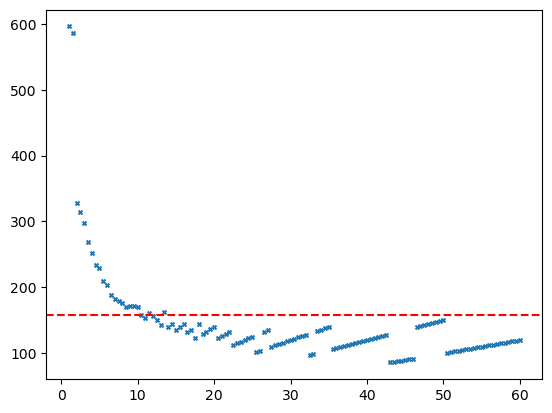

In [88]:
# On vérifie ce que ça veut dire pour le graphe ! 
plt.scatter(résol,lengths,marker="x",s=8)
plt.axhline(y=threshold, color='r', linestyle='--')

In [99]:
np.max(résol[lengths > threshold])

13.5

In [100]:
# On sélectionne dans les données dont la longueur est supérieure à threshold la résolution la plus grossière
np.max(résol[lengths > threshold])

13.5

Dans ce cas, on estime qu'avec une hauteur initiale de neige de 3m, la résolution ne peut théoriquement pas être supérieure à 13.5 m si on veut que Snowslide fonctionne correctment. Répétons l'expérience pour différentes hauteurs initiales et comparons les rapports snd0/résolution. 

In [106]:
# On copie les données
résol = np.copy(y0[0])
lengths = np.copy(y0[1])
threshold = np.mean(lengths[résol>10]) + 2*np.std(lengths[résol>10])
np.max(résol[lengths > threshold])

50.0

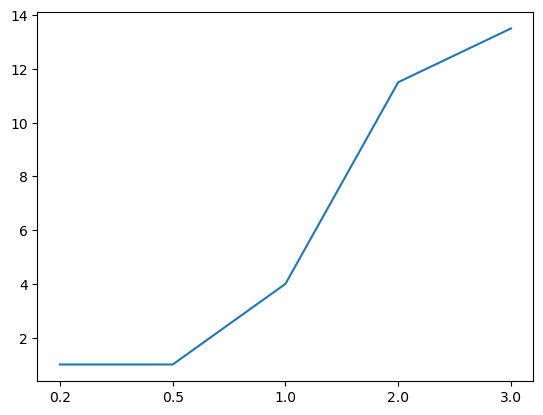

In [107]:
# On récupère alors les données suivantes
resol_max = [1,1,4.0,11.5,13.5]
hauteurs_init = ['0.2','0.5','1.0','2.0','3.0']
plt.plot(hauteurs_init,resol_max)

___________
### ANCIEN TRAVAIL : pour le rapport

L'objectif ensuite est d'afficher un graphique qui distingue la variabilité des résultats en fonction d'un indicateur. Quelques chose qui permette d'évaluer un indicateur seuil à partir duquel les résultats sont trop variables...

In [183]:
# Calcul de la variance, moyenne et écart types des résultats pour SND0 = 1m
data = np.copy(y3[1])
print("La moyenne est : ", np.mean(data)) 
print("La variance est : ", np.var(data))
print("L'écart type est : ", np.std(data))

La moyenne est :  111.40756302521008
La variance est :  1423.2477579266995
L'écart type est :  37.725956024025415


Ce qu'on va faire c'est qu'on va récupérer les données à chaque quantité initiale : 
- on va les classer par ordre de résolution croissante (de 60m à 1m)
- on va déterminer un sous groupe de référence et on va ajouter à ce groupe successivement une valeur de distance associée à une résolution grande au groupe et calculer la déviation standard qu'on retient. 
- Puis on affiche sur un graphe la déviation standard avec la résolution maximale du groupe. 
- A qté initiale donnée, on détermine à quelle résolution la déviation standard commence à déconner.

In [206]:
# # On classe dans l'ordre
# abscisses = y4[0]
# valeurs = y4[1]

# # Regrouper les paires d'abscisses et de valeurs
# paires = list(zip(abscisses, valeurs))

# # Trier les paires en fonction des abscisses
# paires_triees = sorted(paires, key=lambda x: x[0])

# # Séparer les abscisses et les valeurs triées
# abscisses_triees, valeurs_triees = zip(*paires_triees)

# # Afficher les données triées
# print(abscisses_triees)
# print(valeurs_triees)

# array = np.array([abscisses_triees,valeurs_triees])
# np.save("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND3sorted.npy",array)

In [208]:
data1 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.2sorted.npy")
data2 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND0.5sorted.npy")
data3 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND1sorted.npy")
data4 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND2sorted.npy")
data5 = np.load("/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/outputs/fct_dist_resol_SND3sorted.npy")

(0.0, 62.95)

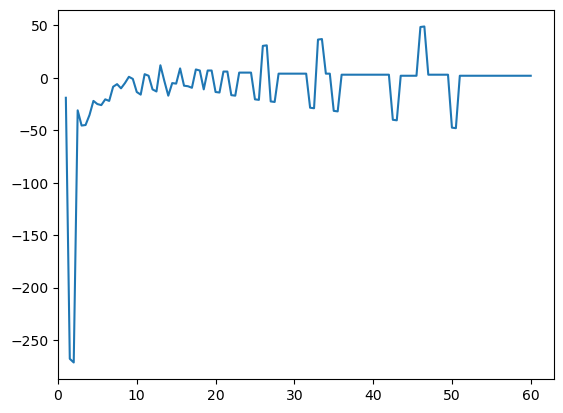

In [238]:
#plt.plot(data1[0],np.gradient(data1[1],data1[0]))
#plt.plot(data2[0],np.gradient(data2[1],data2[0]))
#plt.plot(data3[0],np.gradient(data3[1],data3[0]))
#plt.plot(data4[0],np.gradient(data4[1],data4[0]))
plt.plot(data5[0],np.gradient(data5[1],data5[0]))
# plt.legend(['SND0=0.2','SND0=0.5','SND0=1','SND0=2','SND0=3'])
plt.xlim(0)

Text(0.5, 1.0, 'Seuil maximal SND0/résolution')

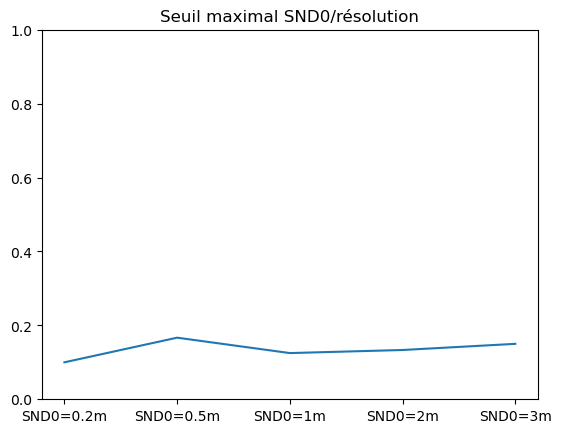

In [246]:
# Il en résulte les ratios :
values = [0.2/2,0.5/3,1/8,2/15,3/20]
plt.plot(['SND0=0.2m','SND0=0.5m','SND0=1m','SND0=2m','SND0=3m'],values)
plt.ylim(0,1)
plt.title('Seuil maximal SND0/résolution')

___

### Affichage et comparaison de profils de dépôt

In [248]:
# On liste les éléments du dossier 
import os
a = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_1.0m.tif"
b = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_2.0m.tif"
c = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_5.0m.tif"
d = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_10m.tif"
e = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_30.0m.tif"
f = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM/DEM_linear_NorthFaces_50.0m.tif"
dem_paths = [a,b,c,d,e,f]

# On lance snowslide sur ces DEMs
statistics = []
SND_tot = []
i = 0
for dem_path in dem_paths :
    # Inputs
    init = 1.0
    dem = rasterio.open(dem_path).read(1)

    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SND_tot.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    statistics.append(dic)
    i = i+1
    print(f"##### Complété : {(i/120)*100}%")

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 0.8333333333333334%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 1.6666666666666667%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 2.5%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 3.3333333333333335%
##### Complété : 4.166666666666666%
##### Complété : 5.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


_____

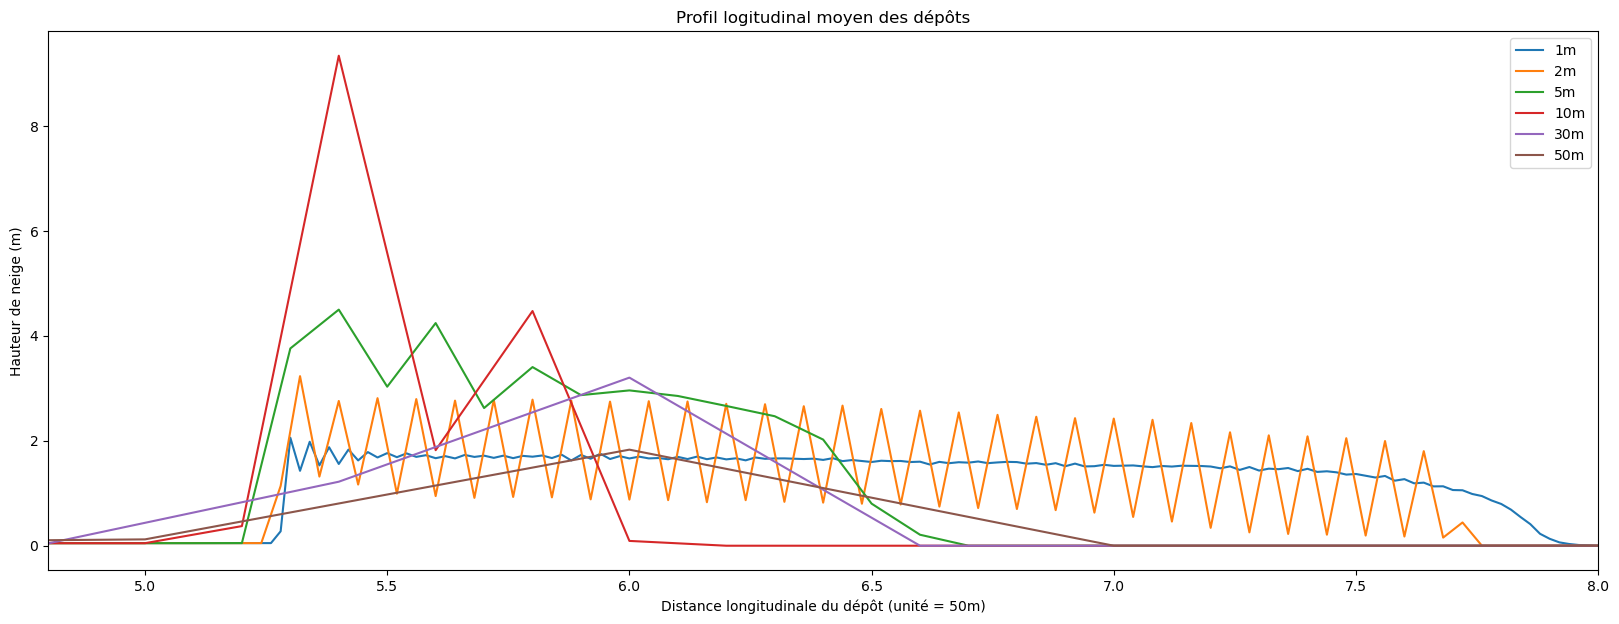

In [294]:
profils=[]
factors=[50,25,10,5,5/3,1]
plt.figure(figsize=(20,7))
for i in range(len(SND_tot)) :
    S = SND_tot[i]
    profil = np.mean(S,axis=1)
    #test = profil[np.where(profil>1)]
    #profils.append(test)
    plt.plot(np.arange(len(SND_tot[i]))/factors[i],profil)
    plt.legend(['1m','2m','5m','10m','30m','50m'])
    plt.xlim(4.8,8)
    plt.title("Profil logitudinal moyen des dépôts")
    plt.xlabel('Distance longitudinale du dépôt (unité = 50m)')
    plt.ylabel('Hauteur de neige (m)')


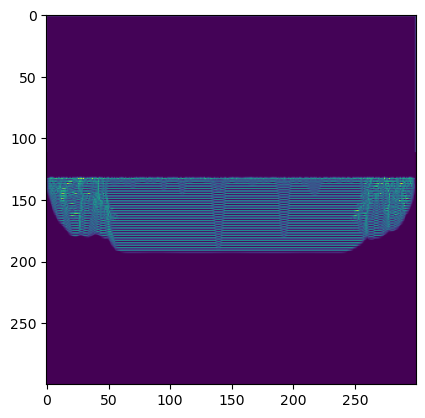

In [281]:
plt.imshow(SND_tot[1])

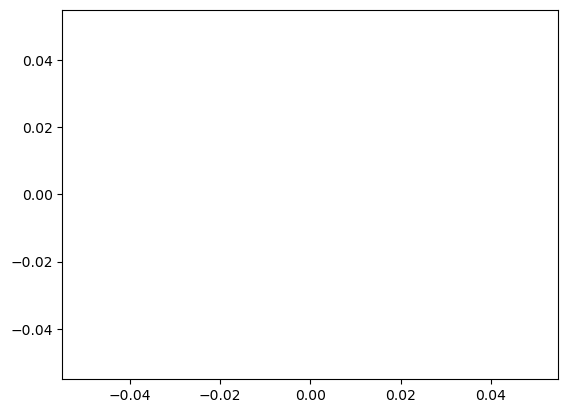

In [275]:
vecteur = profils[5]
nouveau_vecteur = np.interp(np.arange(0, len(vecteur)-1,5/50), np.arange(len(vecteur)), vecteur)
plt.plot(nouveau_vecteur)

In [ ]:
# Calcul de statistiques sur des DEMs réels m

(30.0, 30.0)

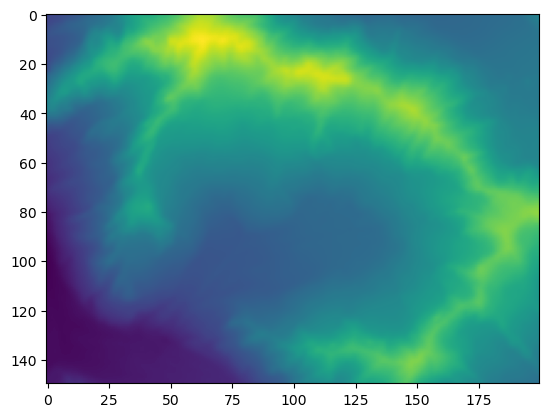

In [297]:
dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Snowslide/3_Inputs/DEMs/DEM_Mt_blanc_recadre.tif"
dem = rasterio.open(dem_path).read(1)
res = rasterio.open(dem_path).res
plt.imshow(dem)


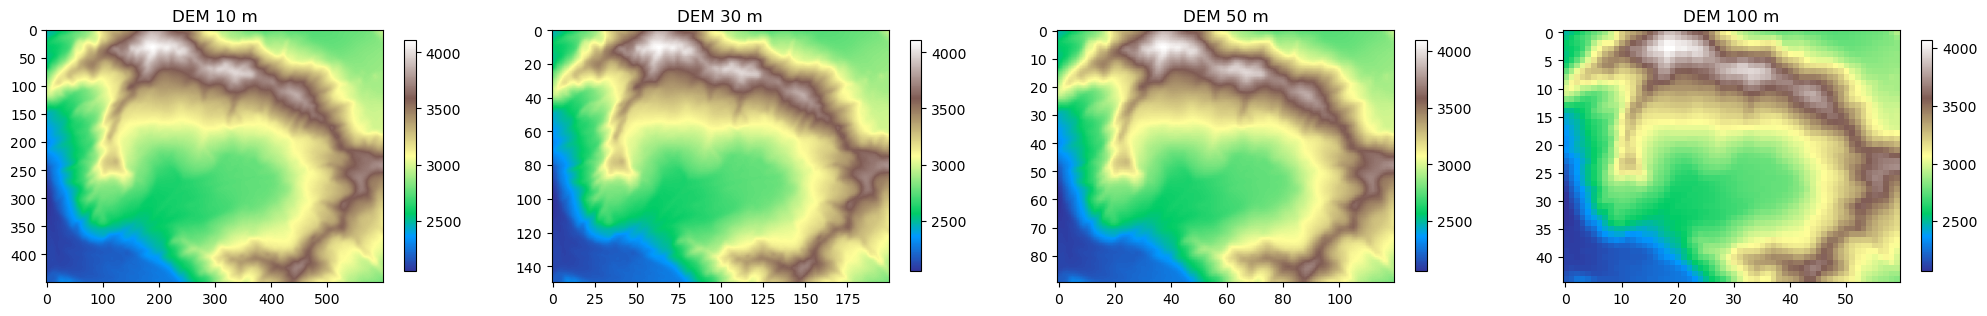

In [318]:
# On liste les éléments du dossier 
import os
dossier = "/Users/llemcf/Desktop/Stage_IGE_2023/NotebooksFinaux_rapport/Data/DEM_talèfre"
if os.path.exists(dossier) and os.path.isdir(dossier):
    dem_paths = [os.path.join(dossier, element) for element in os.listdir(dossier)]
res = [10,30,50,100]
fig,ax = plt.subplots(1,4,figsize=(25,5))
for i in range(len(dem_paths)):
    dem = rasterio.open(dem_paths[i]).read(1)
    plot = ax[i].imshow(dem,cmap='terrain')
    plt.colorbar(plot,ax=ax[i],shrink=0.6)
    ax[i].set_title(f"DEM {res[i]} m")
# plt.suptitle('Modèles numériques de terrain du glacier de talèfre à différentes résolutions')

In [326]:
# On lance snowslide sur ces DEMs
statistics = []
SND_tot = []
SND_stat = []
i = 0
for dem_path in dem_paths :
    # Inputs
    init = 1.0
    dem = rasterio.open(dem_path).read(1)

    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 200)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SND_tot.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    SND_stat.append(SND_test)
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)
    indices_non_nan = np.where(~np.isnan(SND_test))
    min_index = np.min(indices_non_nan[0])
    max_index = np.max(indices_non_nan[0])
    dic["deposit_max_distance"] = (max_index - min_index)*resolution

    statistics.append(dic)
    i = i+1
    print(f"##### Complété : {(i/4)*100}%")

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 25.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 50.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


##### Complété : 75.0%
##### Complété : 100.0%


/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


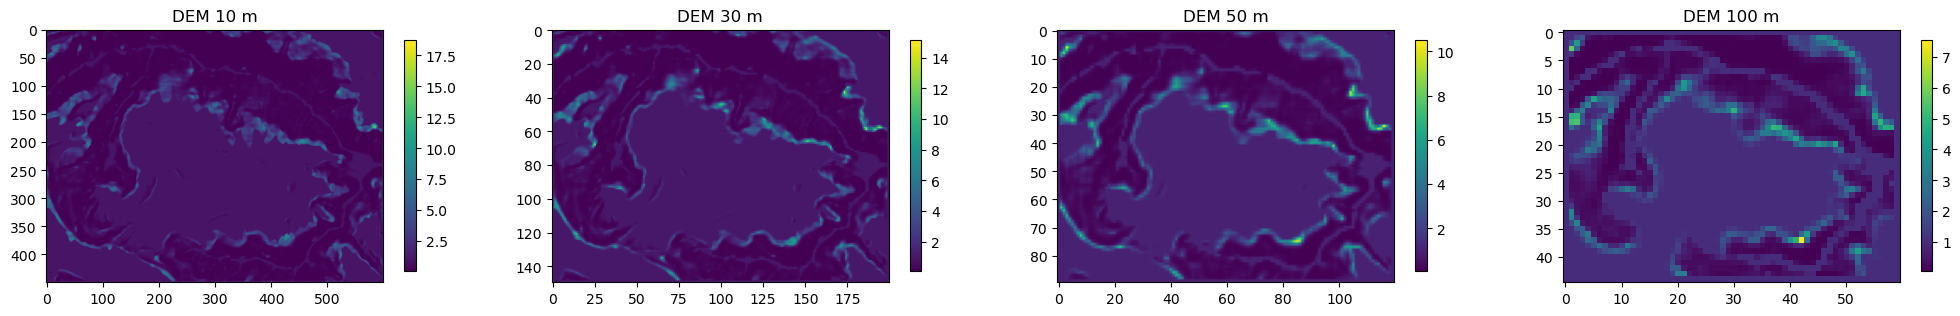

In [327]:
fig,ax = plt.subplots(1,4,figsize=(25,5))
for i in range(4) :
    plot = ax[i].imshow(SND_tot[i])
    plt.colorbar(plot,ax=ax[i],shrink=0.6)
    ax[i].set_title(f"DEM {res[i]} m")

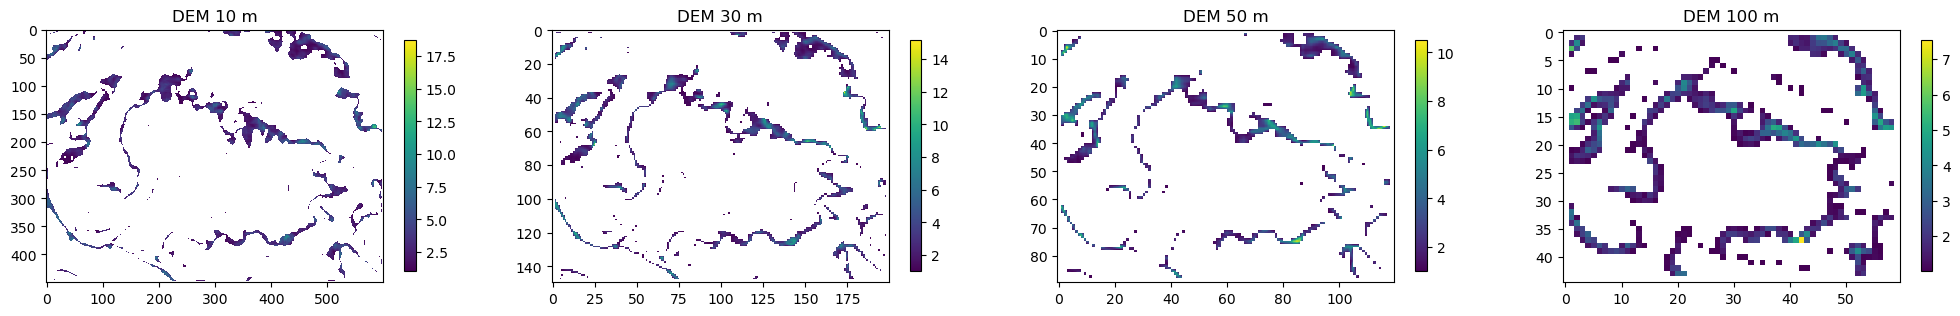

In [328]:
fig,ax = plt.subplots(1,4,figsize=(25,5))
for i in range(4) :
    plot = ax[i].imshow(SND_stat[i])
    plt.colorbar(plot,ax=ax[i],shrink=0.6)
    ax[i].set_title(f"DEM {res[i]} m")

Text(0, 0.5, 'Hauteurs (m)')

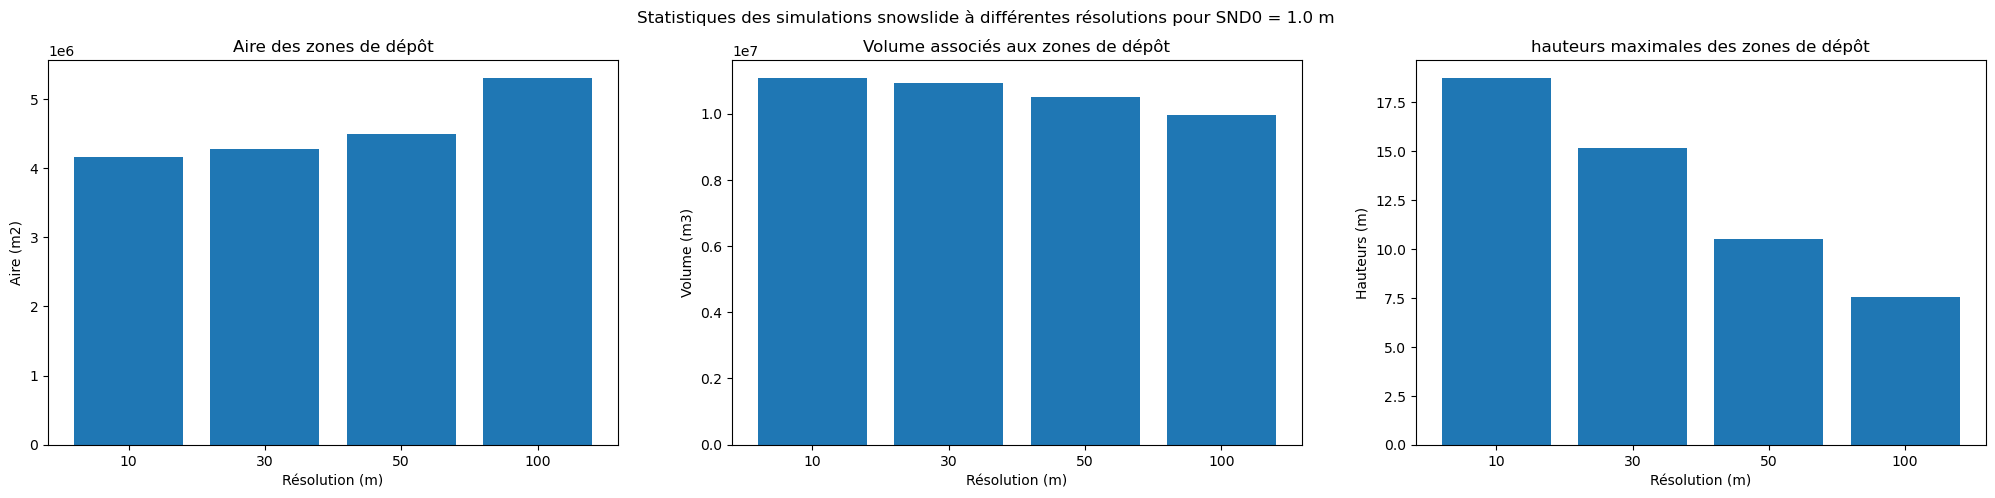

In [338]:
areas = []
volumes = []
heights = []
resol_dems = ['10','30','50','100']
for i in range(len(dem_paths)):
    dem = rasterio.open(dem_paths[i]).read(1)
    res = rasterio.open(dem_paths[i]).res
    # SND0 = np.full(np.shape(dem),1.0)
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])

fig,ax = plt.subplots(1,3,figsize=(25,5))
plt.suptitle(f"Statistiques des simulations snowslide à différentes résolutions pour SND0 = {init} m")
ax[0].bar(resol_dems,areas)
ax[0].set_title('Aire des zones de dépôt')
ax[0].set_xlabel('Résolution (m)')
ax[0].set_ylabel('Aire (m2)')
ax[1].bar(resol_dems,volumes)
ax[1].set_title('Volume associés aux zones de dépôt')
ax[1].set_xlabel('Résolution (m)')
ax[1].set_ylabel('Volume (m3)')
ax[2].bar(resol_dems,heights)
ax[2].set_title('hauteurs maximales des zones de dépôt')
ax[2].set_xlabel('Résolution (m)')
ax[2].set_ylabel('Hauteurs (m)')

Text(0, 0.5, 'Ecart à la moyenne')

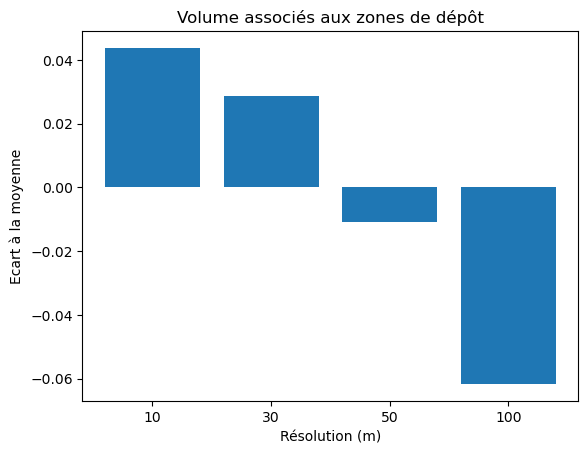

In [343]:
vol = np.array(volumes)
mean = np.mean(vol)
vol = (vol-mean)/mean

plt.bar(resol_dems,vol)
plt.title('Volume associés aux zones de dépôt')
plt.xlabel('Résolution (m)')
plt.ylabel('Ecart à la moyenne')

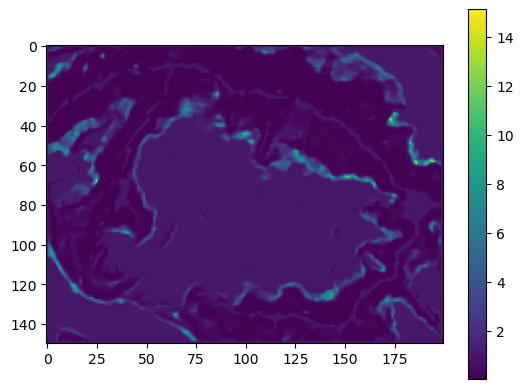

In [323]:
plt.imshow(SND_tot[1])
plt.colorbar()

# BROUILLON ANCIEN

In [95]:
from snowslide.snowslide_main import snowslide_base

# On lance snowslide sur ces DEMs
SNDs = []
SND_stats = []
statistics = [] 
for dem_path in dem_paths :
    # Inputs
    init = 0.5
    dem = rasterio.open(dem_path).read(1)
    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 800)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SNDs.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)

    SND_stats.append(SND_test)
    statistics.append(dic)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

AFFICHAGE DES STATISTIQUES :
Pour le DEM 2.0 m :
    Deposit area : 207060.0 m2 :
    Deposit volume : 28513.824198194012 m3 :
    Max height : 4.72739144684161 m :
Pour le DEM 5.0 m :
    Deposit area : 214900.0 m2 :
    Deposit volume : 27356.31826758747 m3 :
    Max height : 3.5802478518213365 m :
Pour le DEM 10.0 m :
    Deposit area : 220600.0 m2 :
    Deposit volume : 24794.334502773665 m3 :
    Max height : 3.0572218069976578 m :
Pour le DEM 20.0 m :
    Deposit area : 231200.0 m2 :
    Deposit volume : 19581.379591555902 m3 :
    Max height : 1.6497096980777588 m :
Pour le DEM 50.0 m :
    Deposit area : 195000.0 m2 :
    Deposit volume : 7875.0 m3 :
    Max height : 0.10398795838539673 m :


IndexError: list index out of range

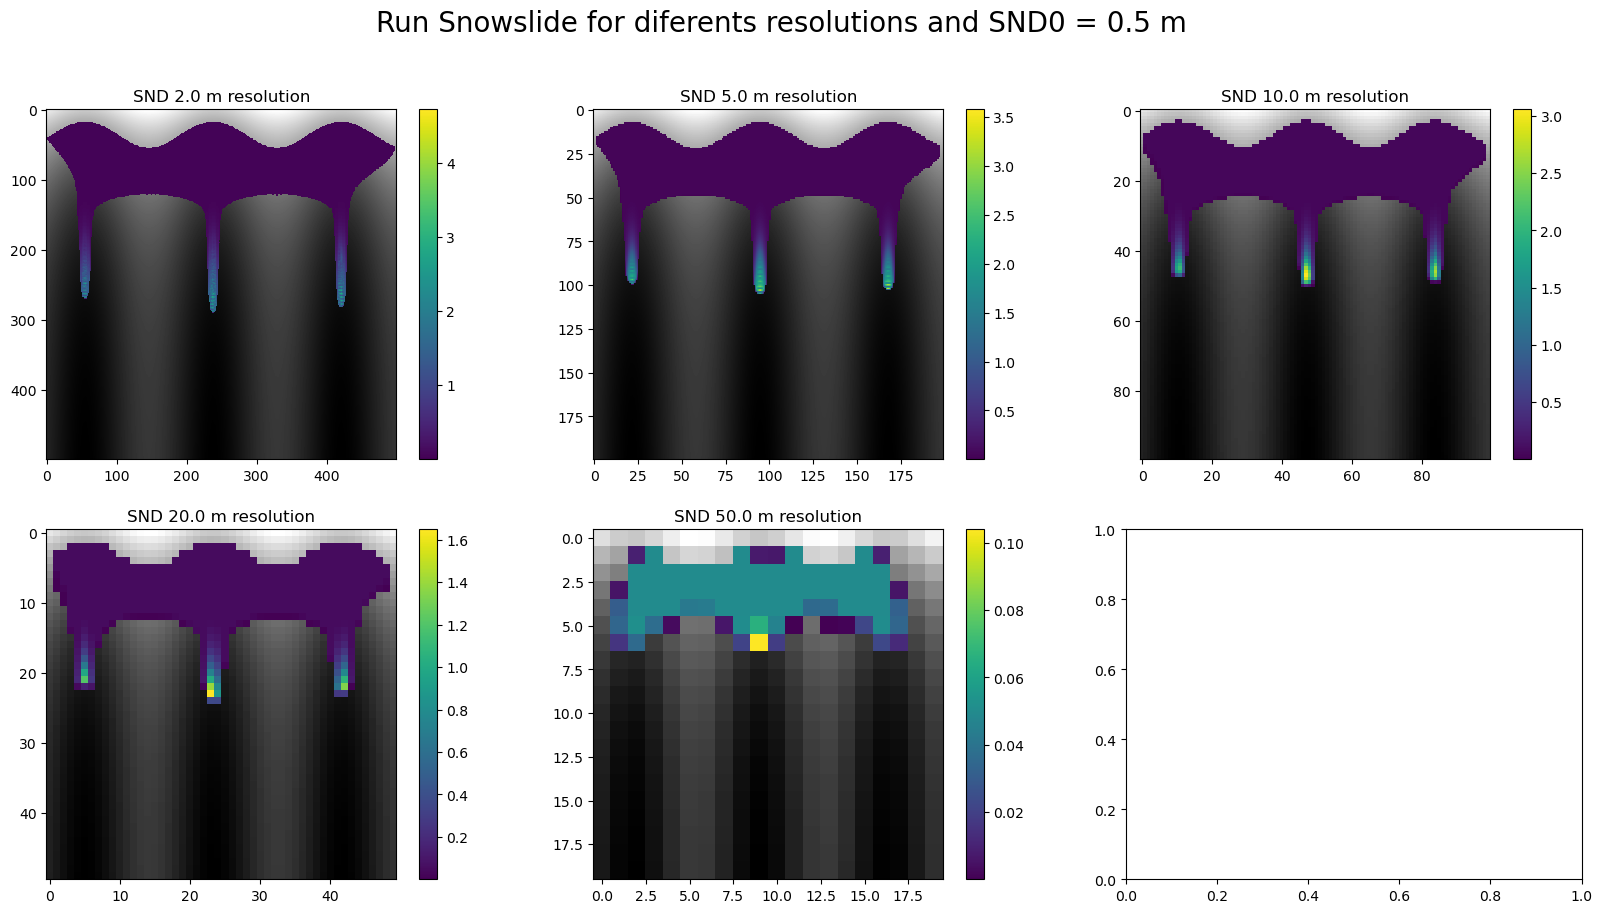

In [96]:
print("AFFICHAGE DES STATISTIQUES :")
for i in range(len(dem_paths)):
    print(f"Pour le DEM {srcs[i].res[0]} m :")
    print(f"    Deposit area : {statistics[i]['deposit_area']} m2 :")
    print(f"    Deposit volume : {statistics[i]['deposit_volume']} m3 :")
    print(f"    Max height : {statistics[i]['max_height']} m :")

fig,ax = plt.subplots(2,3,figsize=(20,10))
for i in range(3) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)

    ax[0,i].imshow(srcs[i].read(1),cmap='gray')
    plot = ax[0,i].imshow(SND_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    
    ax[1,i].imshow(srcs[i+3].read(1),cmap='gray')
    plot = ax[1,i].imshow(SND_stats[i+3])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+3].res[0]} m resolution")

In [ ]:
areas = []
volumes = []
heights = []
total_volume = []
init_volume = []
resol_dems = []
for i in range(len(dem_paths)):
    SND0 = np.zeros(np.shape(srcs[i].read(1)))
    SND0[np.where(srcs[i].read(1) > 800)] = init
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    total_volume.append(np.sum(SNDs[i])*(srcs[i].res[0])**2)
    init_volume.append(np.sum(SND0)*(srcs[i].res[0])**2)
    
    resol_dems.append(str(srcs[i].res[0]) + "m res")

fig,ax = plt.subplots(1,4,figsize=(25,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,total_volume)
ax[0].scatter(resol_dems,init_volume)
ax[0].set_title('Total snow heights')
ax[1].bar(resol_dems,areas)
ax[1].set_title('Deposits areas on the dems')
ax[2].bar(resol_dems,volumes)
ax[2].set_title('Deposits volumes on the dems')
ax[3].bar(resol_dems,heights)
ax[3].set_title('Max heights on the dems')

___

In [54]:
from snowslide.snowslide_main import snowslide_base

dem_paths = [dem_path2,dem_path3,dem_path4,dem_path5,dem_path6,dem_path7]

# On lance snowslide sur ces DEMs
SNDs = []
SND_stats = []
statistics = [] 
for dem_path in dem_paths :
    # Inputs
    init = 2.0
    dem = rasterio.open(dem_path).read(1)
    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 450)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SNDs.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)

    SND_stats.append(SND_test)
    statistics.append(dic)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

AFFICHAGE DES STATISTIQUES :
Pour le DEM 0.5 m :
    Deposit area : 165172.0 m2 :
    Deposit volume : 135322.47282147247 m3 :
    Max height : 4.8116357272006045 m :
Pour le DEM 1.0 m :
    Deposit area : 144944.0 m2 :
    Deposit volume : 132267.17389266085 m3 :
    Max height : 6.726122548803092 m :
Pour le DEM 2.0 m :
    Deposit area : 121450.0 m2 :
    Deposit volume : 128866.75392474211 m3 :
    Max height : 6.465861732516729 m :
Pour le DEM 5.0 m :
    Deposit area : 108000.0 m2 :
    Deposit volume : 109463.18645480774 m3 :
    Max height : 12.428109217183895 m :
Pour le DEM 10.0 m :
    Deposit area : 110400.0 m2 :
    Deposit volume : 96685.96176590104 m3 :
    Max height : 7.688771271229487 m :
Pour le DEM 20.0 m :
    Deposit area : 125000.0 m2 :
    Deposit volume : 40036.68660957751 m3 :
    Max height : 1.6567213430059544 m :


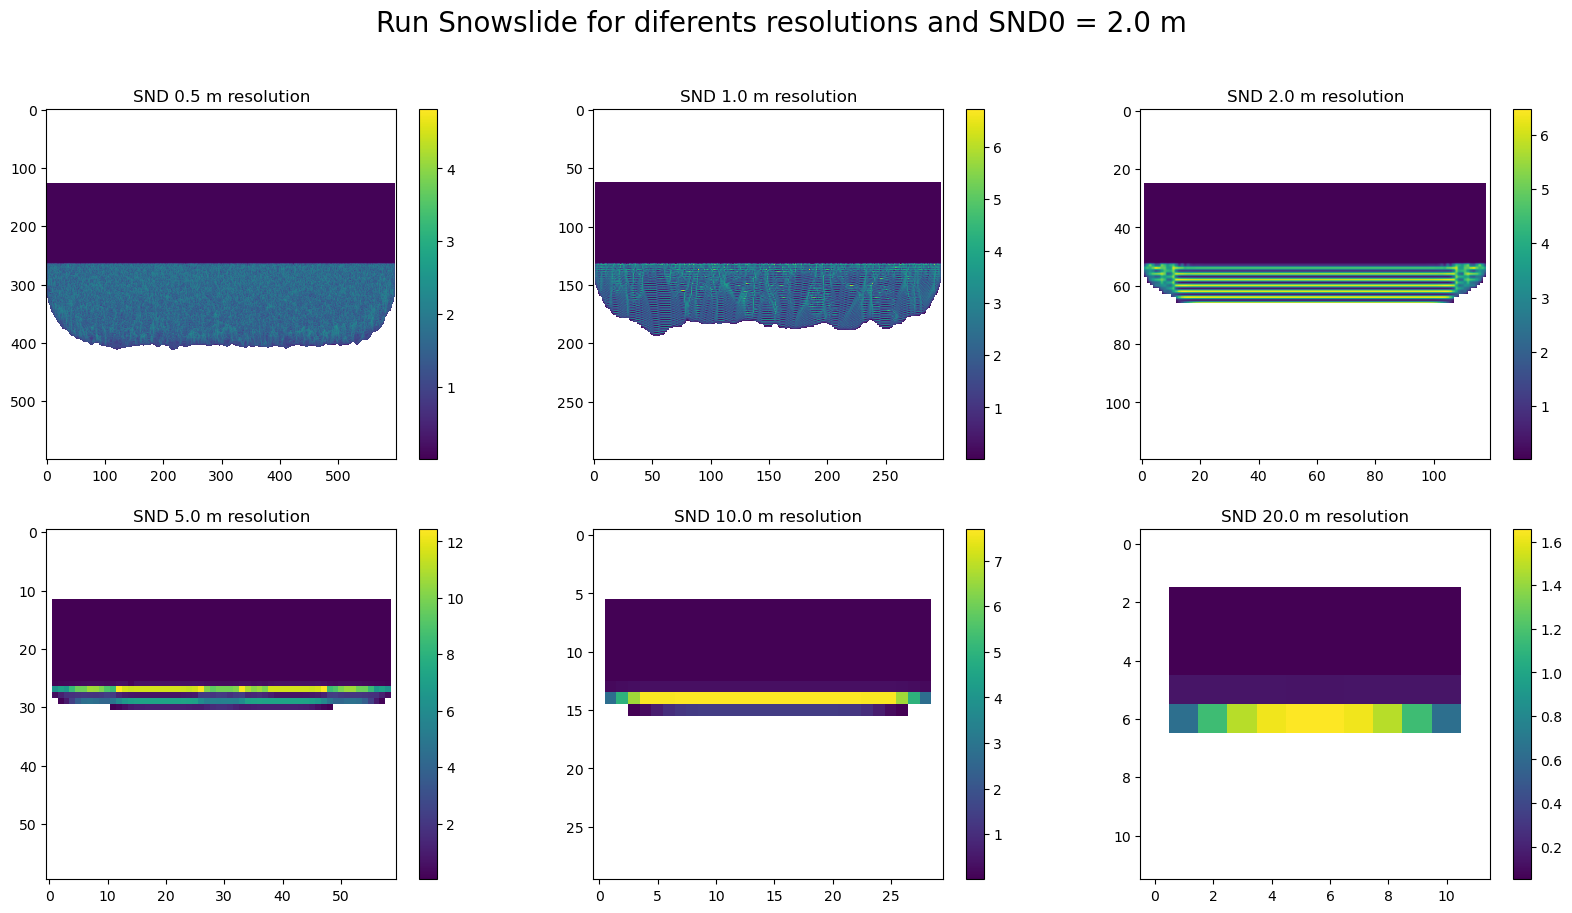

In [55]:
print("AFFICHAGE DES STATISTIQUES :")
for i in range(len(dem_paths)):
    print(f"Pour le DEM {srcs[i].res[0]} m :")
    print(f"    Deposit area : {statistics[i]['deposit_area']} m2 :")
    print(f"    Deposit volume : {statistics[i]['deposit_volume']} m3 :")
    print(f"    Max height : {statistics[i]['max_height']} m :")

fig,ax = plt.subplots(2,3,figsize=(20,10))
for i in range(len(dem_paths)//2) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)
    plot = ax[0,i].imshow(SND_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    plot = ax[1,i].imshow(SND_stats[i+3])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+3].res[0]} m resolution")

Text(0.5, 1.0, 'Max heights on the dems')

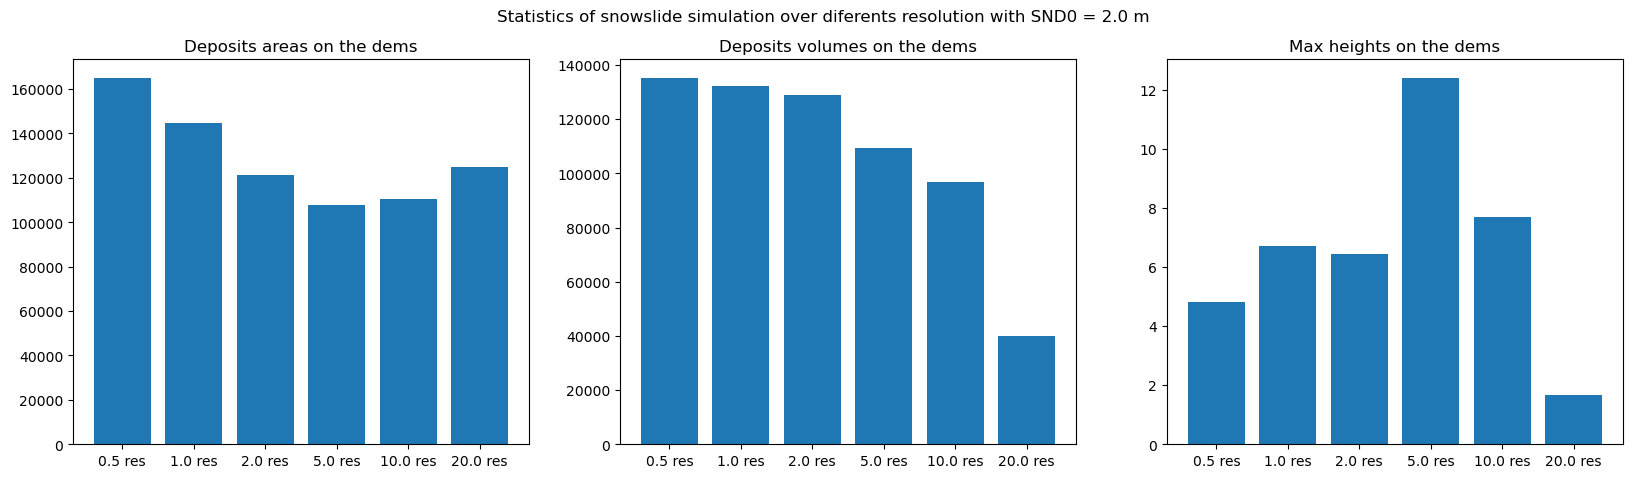

In [56]:
areas = []
volumes = []
heights = []
resol_dems = []
for i in range(len(dem_paths)):
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    resol_dems.append(str(srcs[i].res[0]) + " res")

fig,ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,areas)
ax[0].set_title('Deposits areas on the dems')
ax[1].bar(resol_dems,volumes)
ax[1].set_title('Deposits volumes on the dems')
ax[2].bar(resol_dems,heights)
ax[2].set_title('Max heights on the dems')

In [57]:
from snowslide.snowslide_main import snowslide_base

dem_paths = [dem_path2,dem_path3,dem_path4,dem_path5,dem_path6,dem_path7]

# On lance snowslide sur ces DEMs
SNDs = []
SND_stats = []
statistics = [] 
for dem_path in dem_paths :
    # Inputs
    init = 0.5
    dem = rasterio.open(dem_path).read(1)
    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 450)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SNDs.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)

    SND_stats.append(SND_test)
    statistics.append(dic)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

AFFICHAGE DES STATISTIQUES :
Pour le DEM 0.5 m :
    Deposit area : 103166.0 m2 :
    Deposit volume : 31348.82000469723 m3 :
    Max height : 5.01738903832503 m :
Pour le DEM 1.0 m :
    Deposit area : 97488.0 m2 :
    Deposit volume : 30759.259223831403 m3 :
    Max height : 5.408320143348111 m :
Pour le DEM 2.0 m :
    Deposit area : 93950.0 m2 :
    Deposit volume : 30084.902152381772 m3 :
    Max height : 4.151834145254623 m :
Pour le DEM 5.0 m :
    Deposit area : 92800.0 m2 :
    Deposit volume : 26077.41570377393 m3 :
    Max height : 3.9383375189631664 m :
Pour le DEM 10.0 m :
    Deposit area : 100800.0 m2 :
    Deposit volume : 22629.906593551073 m3 :
    Max height : 1.7143944825683364 m :
Pour le DEM 20.0 m :
    Deposit area : 125000.0 m2 :
    Deposit volume : 9766.595435409143 m3 :
    Max height : 0.16169968817757058 m :


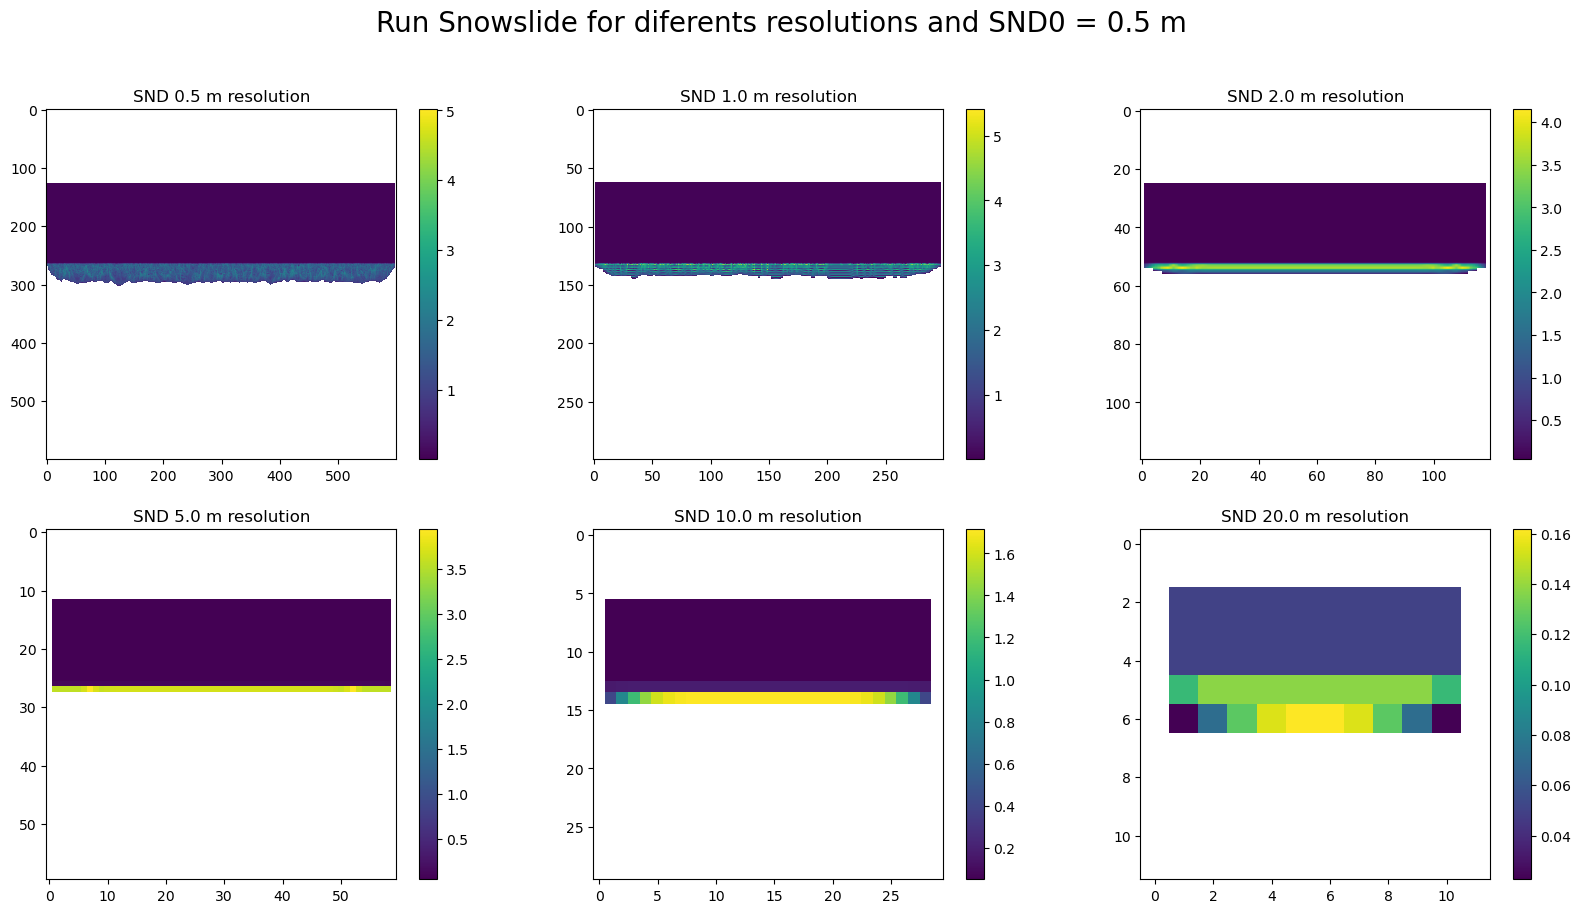

In [58]:
print("AFFICHAGE DES STATISTIQUES :")
for i in range(len(dem_paths)):
    print(f"Pour le DEM {srcs[i].res[0]} m :")
    print(f"    Deposit area : {statistics[i]['deposit_area']} m2 :")
    print(f"    Deposit volume : {statistics[i]['deposit_volume']} m3 :")
    print(f"    Max height : {statistics[i]['max_height']} m :")

fig,ax = plt.subplots(2,3,figsize=(20,10))
for i in range(len(dem_paths)//2) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)
    plot = ax[0,i].imshow(SND_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    plot = ax[1,i].imshow(SND_stats[i+3])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+3].res[0]} m resolution")

Text(0.5, 1.0, 'Max heights on the dems')

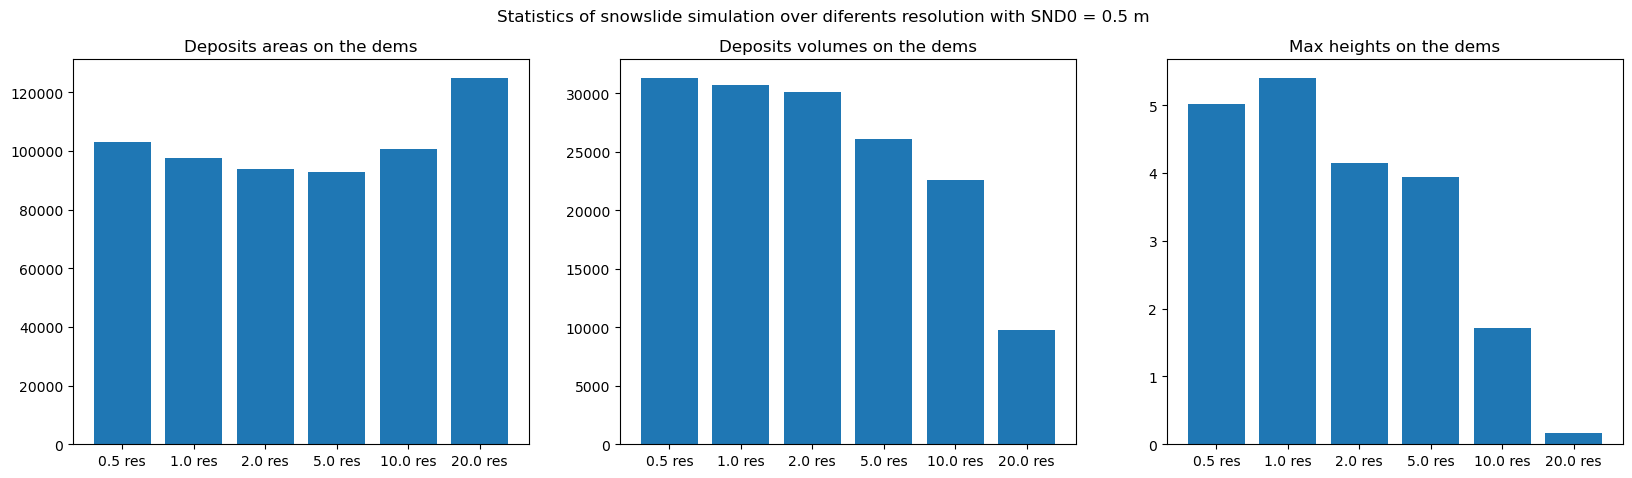

In [59]:
areas = []
volumes = []
heights = []
resol_dems = []
for i in range(len(dem_paths)):
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    resol_dems.append(str(srcs[i].res[0]) + " res")

fig,ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,areas)
ax[0].set_title('Deposits areas on the dems')
ax[1].bar(resol_dems,volumes)
ax[1].set_title('Deposits volumes on the dems')
ax[2].bar(resol_dems,heights)
ax[2].set_title('Max heights on the dems')

In [60]:
from snowslide.snowslide_main import snowslide_base

dem_paths = [dem_path2,dem_path3,dem_path4,dem_path5,dem_path6,dem_path7]

# On lance snowslide sur ces DEMs
SNDs = []
SND_stats = []
statistics = [] 
for dem_path in dem_paths :
    # Inputs
    init = 0.1
    dem = rasterio.open(dem_path).read(1)
    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 450)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SNDs.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)

    SND_stats.append(SND_test)
    statistics.append(dic)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

AFFICHAGE DES STATISTIQUES :
Pour le DEM 0.5 m :
    Deposit area : 23788.0 m2 :
    Deposit volume : 2332.0290436733276 m3 :
    Max height : 0.10000000000000003 m :
Pour le DEM 1.0 m :
    Deposit area : 69332.0 m2 :
    Deposit volume : 3437.976358089567 m3 :
    Max height : 0.05000002938541713 m :
Pour le DEM 2.0 m :
    Deposit area : 69100.0 m2 :
    Deposit volume : 3419.562160797122 m3 :
    Max height : 0.0500000009061997 m :
Pour le DEM 5.0 m :
    Deposit area : 64000.0 m2 :
    Deposit volume : 3049.827359062842 m3 :
    Max height : 0.05000000005984506 m :
Pour le DEM 10.0 m :
    Deposit area : 57600.0 m2 :
    Deposit volume : 2642.8691201595916 m3 :
    Max height : 0.05000000000236832 m :
Pour le DEM 20.0 m :
    Deposit area : 25000.0 m2 :
    Deposit volume : 1176.776695296637 m3 :
    Max height : 0.049999999999999996 m :


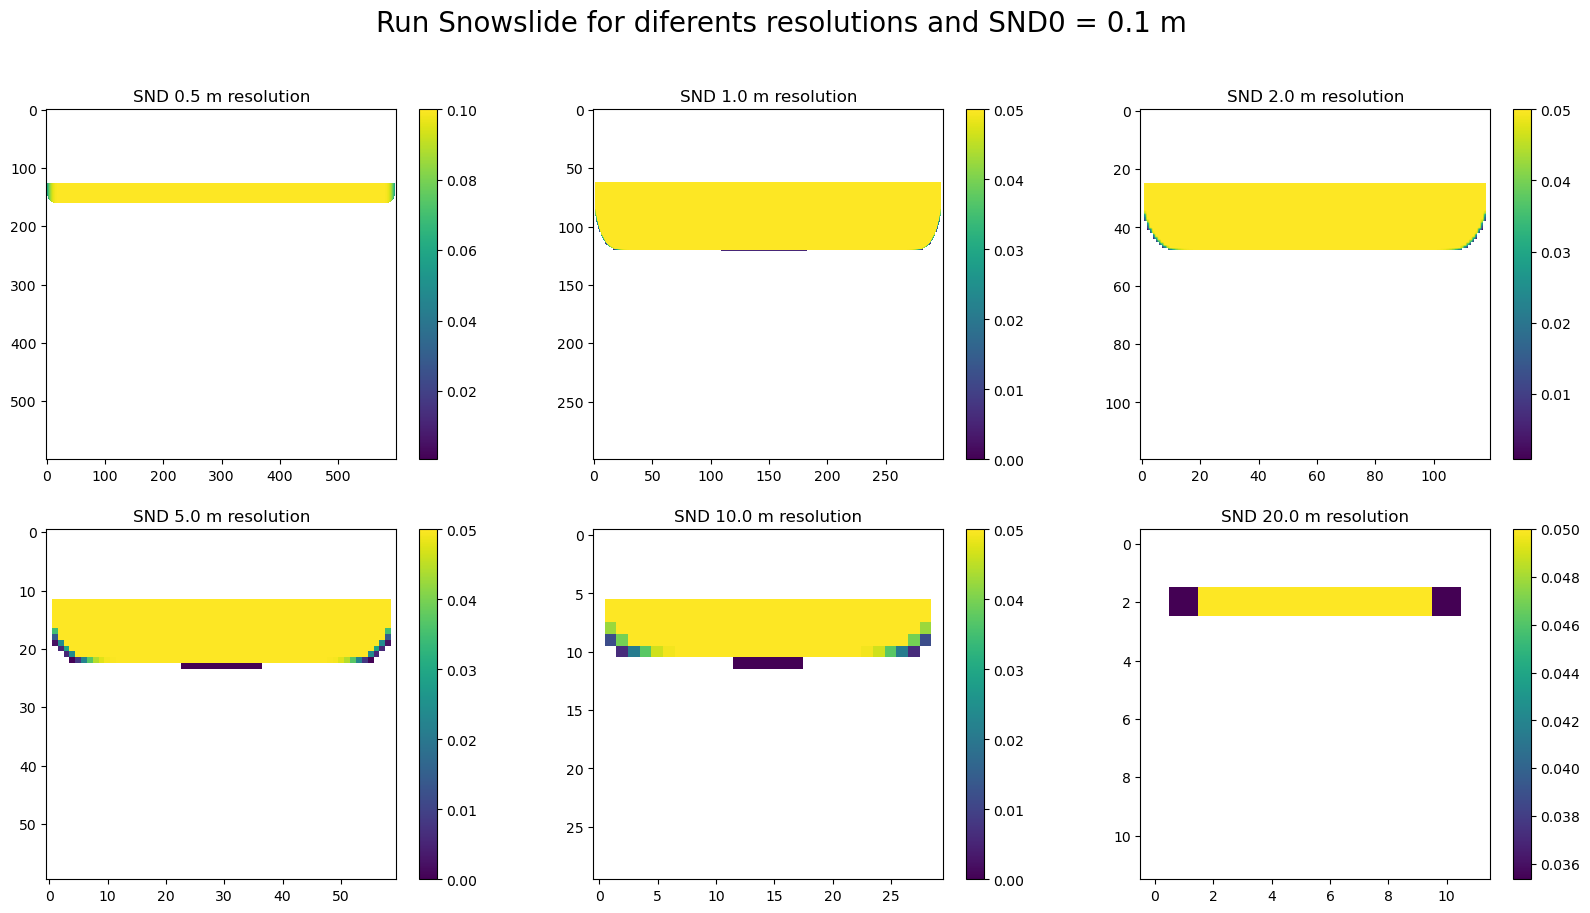

In [61]:
print("AFFICHAGE DES STATISTIQUES :")
for i in range(len(dem_paths)):
    print(f"Pour le DEM {srcs[i].res[0]} m :")
    print(f"    Deposit area : {statistics[i]['deposit_area']} m2 :")
    print(f"    Deposit volume : {statistics[i]['deposit_volume']} m3 :")
    print(f"    Max height : {statistics[i]['max_height']} m :")

fig,ax = plt.subplots(2,3,figsize=(20,10))
for i in range(len(dem_paths)//2) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)
    plot = ax[0,i].imshow(SND_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    plot = ax[1,i].imshow(SND_stats[i+3])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+3].res[0]} m resolution")

Text(0.5, 1.0, 'Max heights on the dems')

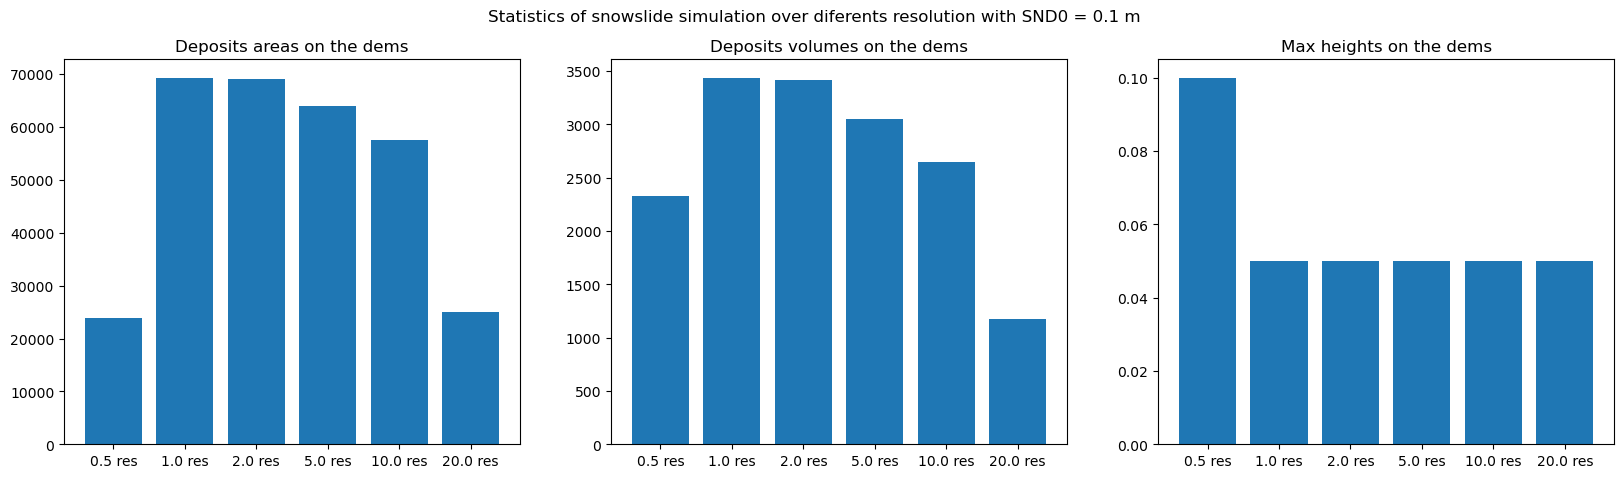

In [62]:
areas = []
volumes = []
heights = []
resol_dems = []
for i in range(len(dem_paths)):
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    resol_dems.append(str(srcs[i].res[0]) + " res")

fig,ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,areas)
ax[0].set_title('Deposits areas on the dems')
ax[1].bar(resol_dems,volumes)
ax[1].set_title('Deposits volumes on the dems')
ax[2].bar(resol_dems,heights)
ax[2].set_title('Max heights on the dems')

In [63]:
from snowslide.snowslide_main import snowslide_base

dem_paths = [dem_path2,dem_path3,dem_path4,dem_path5,dem_path6,dem_path7]

# On lance snowslide sur ces DEMs
SNDs = []
SND_stats = []
statistics = [] 
for dem_path in dem_paths :
    # Inputs
    init = 5.0
    dem = rasterio.open(dem_path).read(1)
    SND0 = np.zeros(np.shape(dem))
    SND0[np.where(dem > 450)] = init
    param_routing = {"routing":"mfd","preprocessing":True}
    
    # Simulation
    SND = snowslide_base(dem_path,SND0,param_routing=param_routing)
    SNDs.append(SND)

    # Statistiques
    dic = {}
    SND_test = np.copy(SND)
    SND_test[np.where(SND <= SND0)] = np.nan
    resolution = rasterio.open(dem_path).res[0]
    dic["deposit_area"] = np.count_nonzero(~np.isnan(SND_test))*resolution**2
    dic["deposit_volume"] = np.nansum(SND_test)*resolution**2
    dic["max_height"] = np.nanmax(SND_test)

    SND_stats.append(SND_test)
    statistics.append(dic)

/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/llemcf/mambaforge/envs/oggm_env/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No

AFFICHAGE DES STATISTIQUES :
Pour le DEM 0.5 m :
    Deposit area : 272623.0 m2 :
    Deposit volume : 319745.3016221645 m3 :
    Max height : 4.809778755023936 m :
Pour le DEM 1.0 m :
    Deposit area : 222360.0 m2 :
    Deposit volume : 331280.05236608715 m3 :
    Max height : 6.923301418438897 m :
Pour le DEM 2.0 m :
    Deposit area : 168925.0 m2 :
    Deposit volume : 320362.8723203302 m3 :
    Max height : 9.574603650077092 m :
Pour le DEM 5.0 m :
    Deposit area : 139400.0 m2 :
    Deposit volume : 276777.6668047671 m3 :
    Max height : 15.129723303383598 m :
Pour le DEM 10.0 m :
    Deposit area : 131200.0 m2 :
    Deposit volume : 241057.12220896813 m3 :
    Max height : 11.642152786861697 m :
Pour le DEM 20.0 m :
    Deposit area : 125000.0 m2 :
    Deposit volume : 100095.4381962127 m3 :
    Max height : 4.639767602544292 m :


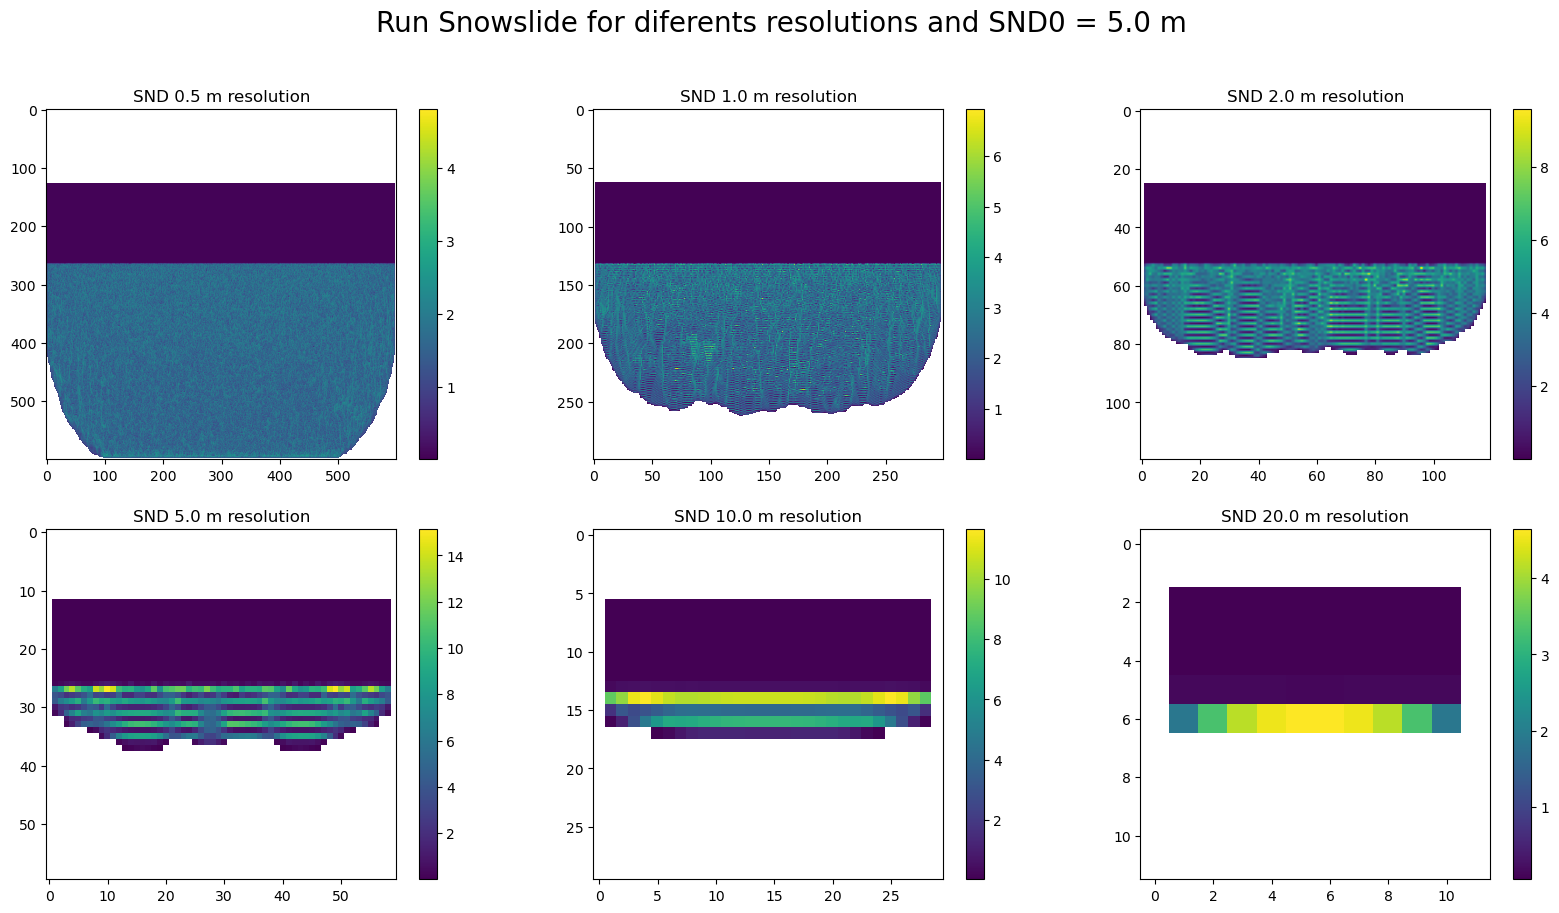

In [64]:
print("AFFICHAGE DES STATISTIQUES :")
for i in range(len(dem_paths)):
    print(f"Pour le DEM {srcs[i].res[0]} m :")
    print(f"    Deposit area : {statistics[i]['deposit_area']} m2 :")
    print(f"    Deposit volume : {statistics[i]['deposit_volume']} m3 :")
    print(f"    Max height : {statistics[i]['max_height']} m :")

fig,ax = plt.subplots(2,3,figsize=(20,10))
for i in range(len(dem_paths)//2) :
    plt.suptitle(f'Run Snowslide for diferents resolutions and SND0 = {init} m',fontsize=20)
    plot = ax[0,i].imshow(SND_stats[i])
    plt.colorbar(plot,ax=ax[0,i])
    ax[0,i].set_title(f"SND {srcs[i].res[0]} m resolution")
    plot = ax[1,i].imshow(SND_stats[i+3])
    plt.colorbar(plot,ax=ax[1,i])
    ax[1,i].set_title(f"SND {srcs[i+3].res[0]} m resolution")

Text(0.5, 1.0, 'Max heights on the dems')

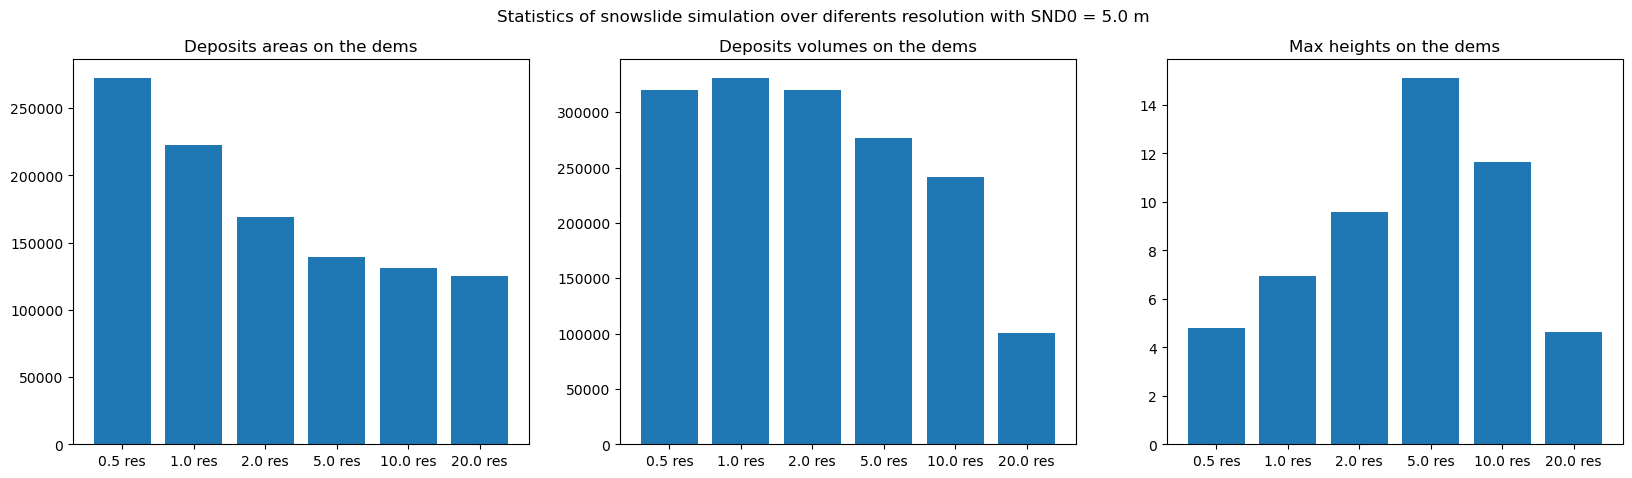

In [65]:
areas = []
volumes = []
heights = []
resol_dems = []
for i in range(len(dem_paths)):
    areas.append(statistics[i]["deposit_area"])
    volumes.append(statistics[i]["deposit_volume"])
    heights.append(statistics[i]["max_height"])
    resol_dems.append(str(srcs[i].res[0]) + " res")

fig,ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle(f"Statistics of snowslide simulation over diferents resolution with SND0 = {init} m")
ax[0].bar(resol_dems,areas)
ax[0].set_title('Deposits areas on the dems')
ax[1].bar(resol_dems,volumes)
ax[1].set_title('Deposits volumes on the dems')
ax[2].bar(resol_dems,heights)
ax[2].set_title('Max heights on the dems')

______